In [ ]:
data_dir = ''
output_dir = ''
name = ''
shuffling = True

if not tf.gfile.Exists(dataset_dir):
    tf.gfile.MakeDirs(dataset_dir)
    


In [ ]:
import sys
import xml.etree.ElementTree as ET
import json
filename = '/home/huiwu1/detection/coco-text/COCO_Text_mini.json'
f = open(filename, encoding='utf-8')
#tree = ET.parse(f)
#print(f)
json_file = json.load(f)
print(json_file)
file_list = json_file['imgs']
print(file_list)

for key in file_list.keys():
    bbox = file_list[key]
    print(bbox)
    
    

In [12]:
import sys
sys.path.append('/home/huiwu1/detection/SSD-Tensorflow')

import random
from datasets.dataset_utils import int64_feature, float_feature, bytes_feature

RAMDOM_SEED = 4242
SAMPLES_PER_FILES = 200

def _get_output_filename(output_dir, name, idx):
    return os.path.join(output_dir, name + "_" + str(idx) + ".tfrecord")

#{'polygon': [342.5074517548974, 315.4072997275363, 372.35819802355405, 315.4072997275363, 372.35819802355405, 327.3455019747273, 342.5074517548974, 327.3455019747273], 
# 'language': 'english', 
# 'area': 356.3642461848053, 
# id': 1186970, 'utf8_string': 'NRT', 
# 'image_id': 294914, 
# 'bbox': [342.5074517548974, 315.4072997275363, 29.85074626865668, 11.938202247190993], 
# 'legibility': 'legible', 
# 'class': 'machine printed'}

def _process_image(dataDir, dataType, img, anns):    
    #print(img)
    #print(anns)
    filename = os.path.join(dataDir, dataType, img['file_name'])
    image_data = tf.gfile.FastGFile(filename, 'rb').read()
    #I = io.imread(os.path.join(dataDir, dataType, img['file_name']))
    shape = [int(img['height']), int(img['width']), 3]
    
    bboxes = []
    labels = []
    labels_text = []
    #difficult = []
    #truncated = []
    areas = []
   
    for i in range(len(anns)):         
        if anns[i]['legibility'] != 'legible' or anns[i]['language'] != 'english':
            continue
        #print(anns[i])    
        labels.append(1)   
        #u'我'.encode('utf-8')
        text = anns[i]['utf8_string'].encode('utf-8')
        labels_text.append(text)
        bbox = anns[i]['bbox']
        bboxes.append((float(bbox[0] / shape[1]),
                       float(bbox[1] / shape[0]),
                       float(bbox[2] / shape[1]),
                       float(bbox[1] / shape[0])
                      ))
        areas.append(anns[i]['area'])  
    return image_data, shape, bboxes, areas, labels, labels_text


def _convert_to_example(image_data, labels, labels_text, bboxes, shape, areas):
    xmin = []
    ymin = []
    xmax = []
    ymax = []
    for bbox in bboxes:
        assert len(bbox) == 4
        [l.append(point) for l, point in zip([ymin, xmin, ymax, xmax], bbox)]
        
    image_format = b'JPEG'
    example = tf.train.Example(features=tf.train.Features(
    feature={
        'image/height': int64_feature(shape[0]),
        'image/width': int64_feature(shape[1]),
        'image/channels': int64_feature(shape[2]),
        'image/shape': int64_feature(shape),
        'image/object/bbox/xmin': float_feature(xmin),
        'image/object/bbox/xmax': float_feature(xmax),
        'image/object/bbox/ymin': float_feature(ymin),
        'image/object/bbox/ymax': float_feature(ymax),
        'image/object/bbox/label': int64_feature(labels),
        'image/object/bbox/label_text': bytes_feature(labels_text),
        'image/object/bbox/area': float_feature(areas),
        'image/format': bytes_feature(image_format),
        'image/encoded': bytes_feature(image_data)
    }))
    return example

def _add_to_tfrecord(dataDir, dataType, img, anns, tfrecord_writer):
    image_data, shape, bboxes, areas, labels, labels_text = _process_image(dataDir, dataType, img, anns)
    example = _convert_to_example(image_data, labels, labels_text, bboxes, shape, areas)
    tfrecord_writer.write(example.SerializeToString())


def run(ct, dataDir, dataType, outputDir, name='coco_train' , shuffling=False):
    # load train images containing at least one legible text
    imgIds = ct.getImgIds(imgIds=ct.train, catIds=[('legibility', 'legible')])

    if shuffling:
        random.seed(RANDOM_SEED)
        random.shuffle(imgIds)
    
    i = 0
    fidx = 0
    while i < len(imgIds):
        img = ct.loadImgs(imgIds[i])[0]
        #print(img)
        #I = io.imread(os.path.join(dataDir, dataType, img['file_name']))
        #print(dataType, img['file_name'])
    
        tf_filename = _get_output_filename(outputDir, name, fidx)
        #print("tf_filename={}".format(tf_filename))
        #print("length = {}".format(len(imgIds)))
    
        with tf.python_io.TFRecordWriter(tf_filename) as tfrecord_writer:
            j = 0
            while i < len(imgIds) and j < SAMPLES_PER_FILES:
                sys.stdout.write('\r >> Converting image {0} / {1}'.format(i+1, len(imgIds)))
                sys.stdout.flush()
            
                img = ct.loadImgs(imgIds[i])[0]
                annIds = ct.getAnnIds(imgIds=img['id'])
                anns = ct.loadAnns(annIds)
                #print(anns)
                print("--------------------")
    
                filename = img['file_name']
                img_name = filename
                _add_to_tfrecord(dataDir, dataType, img, anns, tfrecord_writer)
                i += 1
                j += 1
                fidx += 1
    print('\nFinished converting the coco-text dataset!')  

In [13]:
import sys
sys.path.append("/home/huiwu1/detection/coco-text")
#reload(sys)  
#sys.setdefaultencoding('utf8')   

import os
import numpy as np
import skimage.io as io

import coco_text
dataDir='/lustre/dataset/COCO2014/'
dataType='train2014'
jsonDir = "/home/huiwu1/dataset/coco-text/"
#dataDir = "/home/huiwu1/dataset/coco-text/"
#dataType = "test2017"

import tensorflow as tf
outputDir = "/home/huiwu1/dataset/coco-text/tfrecords"

ct = coco_text.COCO_Text(os.path.join(jsonDir, 'COCO_Text.json'))
ct.info()
run(ct, dataDir, dataType, outputDir)             
    
    

loading annotations into memory...
0:00:01.637175
creating index...
index created!
url: http://vision.cornell.edu/se3/coco-text/
date_created: 2017-03-28
version: 1.4
description: This is 1.4 version of the 2017 COCO-Text dataset.
author: COCO-Text group
 >> Converting image 1260 / 15124--------------------
{'polygon': [118, 140.60550811603747, 134.72351685419684, 140.60550811603747, 134.72351685419684, 150.96575228282572, 118, 150.96575228282572], 'language': 'english', 'area': 173.25971793687782, 'id': 1008880, 'utf8_string': '£14', 'image_id': 2639, 'bbox': [118, 140.60550811603747, 16.723516854196845, 10.360244166788249], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [94.16133785247803, 143.95738983154297, 110.9758996963501, 143.95738983154297, 110.9758996963501, 155.32233428955078, 94.16133785247803, 155.32233428955078], 'language': 'english', 'area': 191.0965614413435, 'id': 1122038, 'utf8_string': '3YS', 'image_id': 2639, 'bbox': [94.16133785247803, 143.957389

 >> Converting image 1263 / 15124--------------------
{'polygon': [192.29226696652375, 234.50871745880102, 206.80535057511653, 234.50871745880102, 206.80535057511653, 277.82633866730356, 192.29226696652375, 277.82633866730356], 'language': 'english', 'area': 628.6722583243492, 'id': 1216142, 'utf8_string': 'DUNKIN', 'image_id': 35407, 'bbox': [192.29226696652375, 234.50871745880102, 14.513083608592783, 43.31762120850253], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [57.22124099731445, 46.25251007080078, 181.46479415893555, 46.25251007080078, 181.46479415893555, 100.7377700805664, 57.22124099731445, 100.7377700805664], 'language': 'english', 'area': 6769.442298548063, 'id': 1216143, 'utf8_string': 'DUNKIN', 'image_id': 35407, 'bbox': [57.22124099731445, 46.25251007080078, 124.2435531616211, 54.485260009765625], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [199.94462014196358, 236.3576403152615, 212.09108159392787, 236.3576403152615, 212.091081593

 >> Converting image 1266 / 15124--------------------
{'polygon': [381.0400161743164, 335.82874298095703, 422.7560043334961, 335.82874298095703, 422.7560043334961, 346.07884979248047, 381.0400161743164, 346.07884979248047], 'language': 'english', 'area': 427.5933343798388, 'id': 1003279, 'utf8_string': 'stagecoach', 'image_id': 297564, 'bbox': [381.0400161743164, 335.82874298095703, 41.71598815917969, 10.250106811523438], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [336.3287296295166, 200.25164604187012, 399.84064292907715, 200.25164604187012, 399.84064292907715, 232.322603225708, 336.3287296295166, 232.322603225708], 'language': 'english', 'area': 2036.8878520938306, 'id': 1003277, 'utf8_string': 'sorry', 'image_id': 297564, 'bbox': [336.3287296295166, 200.25164604187012, 63.51191329956055, 32.07095718383789], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [389, 221, 439, 221, 439, 230, 389, 230], 'language': 'english', 'area': 450, 'id': 1003276

 >> Converting image 1273 / 15124--------------------
{'polygon': [0.6868351105720766, 526.4202494560918, 50.78683511057208, 526.4202494560918, 50.78683511057208, 568.5468317345728, 0.6868351105720766, 568.5468317345728], 'language': 'english', 'area': 2110.5417721518993, 'id': 1060919, 'utf8_string': 'giridhar', 'image_id': 559720, 'bbox': [0.6868351105720766, 526.4202494560918, 50.1, 42.126582278481024], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1274 / 15124--------------------
{'polygon': [215.18435668945312, 85.02350616455078, 350.3761291503906, 85.02350616455078, 350.3761291503906, 163.45653533935547, 215.18435668945312, 163.45653533935547], 'language': 'english', 'area': 10603.500233622268, 'id': 1115984, 'utf8_string': 'sydney', 'image_id': 526953, 'bbox': [215.18435668945312, 85.02350616455078, 135.1917724609375, 78.43302917480469], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [0.4060859680175781, 136.5191993713379, 46.6865768

 >> Converting image 1281 / 15124--------------------
{'polygon': [349, 310, 486, 310, 486, 320, 349, 320], 'language': 'english', 'area': 1370, 'id': 1009432, 'utf8_string': 'www.flickr.com/photos/nain', 'image_id': 428663, 'bbox': [349, 310, 137, 10], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1282 / 15124--------------------
{'polygon': [23, 283.9805245435837, 167, 283.9805245435837, 167, 353.9390861812389, 23, 353.9390861812389], 'language': 'english', 'area': 10074.032875822346, 'id': 1011165, 'utf8_string': 'emirates', 'image_id': 100985, 'bbox': [23, 283.9805245435837, 144, 69.95856163765518], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [347.79486656188965, 191.2768669128418, 397.7404727935791, 191.2768669128418, 397.7404727935791, 227.7878303527832, 347.79486656188965, 227.7878303527832], 'language': 'english', 'area': 1823.5622031109233, 'id': 1158046, 'utf8_string': 'RF', 'image_id': 100985, 'bbox': [347.79486656188965, 191.

 >> Converting image 1288 / 15124--------------------
{'polygon': [2.763007164001465, 88.12743282318115, 25.60573673248291, 88.12743282318115, 25.60573673248291, 107.1665735244751, 2.763007164001465, 107.1665735244751], 'language': 'english', 'area': 434.90594225592577, 'id': 1222576, 'utf8_string': '731', 'image_id': 494222, 'bbox': [2.763007164001465, 88.12743282318115, 22.842729568481445, 19.039140701293945], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [0, 92.6829472175782, 3.6366761296252377, 92.6829472175782, 3.6366761296252377, 105.92393121566755, 0, 105.92393121566755], 'language': 'english', 'area': 48.15317043860127, 'id': 1222577, 'utf8_string': 'P', 'image_id': 494222, 'bbox': [0, 92.6829472175782, 3.6366761296252377, 13.240983998089348], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1289 / 15124--------------------
{'polygon': [431, 0, 473, 0, 473, 10, 431, 10], 'language': 'english', 'area': 420, 'id': 1018878, 'utf8_string'

 >> Converting image 1295 / 15124--------------------
{'polygon': [31, 105, 270.6247496327336, 105, 270.6247496327336, 210.6563432039826, 31, 210.6563432039826], 'language': 'english', 'area': 25317.874787364504, 'id': 1027404, 'utf8_string': 'pistoia', 'image_id': 461464, 'bbox': [31, 105, 239.6247496327336, 105.6563432039826], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1296 / 15124--------------------
{'polygon': [26.255510834150748, 179.76967551707503, 26.255509826249657, 156.71158721446272, 38.254819366044565, 156.71158668995622, 38.254820373945655, 179.76967499256853], 'language': 'english', 'area': 276.68116847295795, 'id': 1223807, 'utf8_string': 'nits', 'image_id': 330395, 'bbox': [26.255509826249657, 156.71158668995622, 11.999310547695998, 23.05808882711881], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [34.96908472790521, 183.26922440074705, 34.969082844116286, 140.17315887950687, 45.67004491076666, 140.17315841175295, 45.670

 >> Converting image 1303 / 15124--------------------
{'polygon': [552.5469417572021, 33.769081115722656, 585.3164615631104, 33.769081115722656, 585.3164615631104, 97.95488739013672, 552.5469417572021, 97.95488739013672], 'language': 'english', 'area': 2103.3380499675986, 'id': 1227241, 'utf8_string': 'T', 'image_id': 395966, 'bbox': [552.5469417572021, 33.769081115722656, 32.7695198059082, 64.18580627441406], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [543.2821655273438, 0, 583.7567749023438, 0, 583.7567749023438, 46.5240364074707, 543.2821655273438, 46.5240364074707], 'language': 'english', 'area': 1883.042200140655, 'id': 1227240, 'utf8_string': 'R', 'image_id': 395966, 'bbox': [543.2821655273438, 0, 40.474609375, 46.5240364074707], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1304 / 15124--------------------
{'polygon': [196, 205, 241, 205, 241, 221, 196, 221], 'language': 'english', 'area': 720, 'id': 1022879, 'utf8_string': '05-0

 >> Converting image 1309 / 15124--------------------
 >> Converting image 1310 / 15124--------------------
{'polygon': [392.2232892891376, 372.4823995999728, 392.2232858756573, 294.39107574743383, 420.2780534842999, 294.39107452112097, 420.2780568977802, 372.4823983736599], 'language': 'english', 'area': 2190.8342439013472, 'id': 1114470, 'utf8_string': 'ARMADK', 'image_id': 2758, 'bbox': [392.2232858756573, 294.39107452112097, 28.05477102212285, 78.09132507885181], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [352.3799926757813, 281.2394366197184, 391.9799926757813, 281.2394366197184, 391.9799926757813, 362.3661971830986, 352.3799926757813, 362.3661971830986], 'language': 'english', 'area': 3212.619718309857, 'id': 1114469, 'utf8_string': 'ARMADK', 'image_id': 2758, 'bbox': [352.3799926757813, 281.2394366197184, 39.599999999999994, 81.12676056338024], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1311 / 15124--------------------
{'polyg

 >> Converting image 1317 / 15124--------------------
{'polygon': [520.2197265625, 221.88912133891216, 549.2487444196429, 221.88912133891216, 549.2487444196429, 241.80543933054395, 520.2197265625, 241.80543933054395], 'language': 'english', 'area': 578.1511506276147, 'id': 1232412, 'utf8_string': 'year', 'image_id': 494297, 'bbox': [520.2197265625, 221.88912133891216, 29.02901785714285, 19.916317991631793], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [548.7842531204224, 226.793550491333, 573.5837888717651, 226.793550491333, 573.5837888717651, 248.71453666687012, 548.7842531204224, 248.71453666687012], 'language': 'english', 'area': 543.6302803649232, 'id': 1232413, 'utf8_string': 'old', 'image_id': 494297, 'bbox': [548.7842531204224, 226.793550491333, 24.799535751342773, 21.92098617553711], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [483.9737159328144, 191.26171483162167, 527.4767675768995, 191.26171483162167, 527.4767675768995, 204.9965703367

 >> Converting image 1320 / 15124--------------------
{'polygon': [162.19594594594594, 172.96202531645568, 188.1418918918919, 172.96202531645568, 188.1418918918919, 183.77215189873422, 162.19594594594594, 183.77215189873422], 'language': 'english', 'area': 280.47895997263254, 'id': 1116787, 'utf8_string': 'citibank', 'image_id': 264926, 'bbox': [162.19594594594594, 172.96202531645568, 25.945945945945965, 10.810126582278539], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [49.858240875819, 29.115274261603453, 58.572409589987714, 29.115274261603453, 58.572409589987714, 41.864672036824004, 49.858240875819, 41.864672036824004], 'language': 'english', 'area': 111.10040321731914, 'id': 1229706, 'utf8_string': '86', 'image_id': 264926, 'bbox': [49.858240875819, 29.115274261603453, 8.714168714168714, 12.749397775220551], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [57.93031294789107, 25.996716532412766, 62.97535799293611, 25.996716532412766, 62.9753579929

 >> Converting image 1325 / 15124--------------------
{'polygon': [259.7123519458545, 227.54430379746833, 318.18950930626056, 227.54430379746833, 318.18950930626056, 253.54936708860762, 259.7123519458545, 253.54936708860762], 'language': 'english', 'area': 1520.7021782432716, 'id': 1059024, 'utf8_string': 'KORAIL', 'image_id': 297704, 'bbox': [259.7123519458545, 227.54430379746833, 58.47715736040609, 26.005063291139283], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1326 / 15124--------------------
{'polygon': [320.98627281188965, 364.36337757110596, 339.6613712310791, 364.36337757110596, 339.6613712310791, 388.19558238983154, 320.98627281188965, 388.19558238983154], 'language': 'english', 'area': 445.06877053598146, 'id': 1140917, 'utf8_string': 'ph', 'image_id': 527082, 'bbox': [320.98627281188965, 364.36337757110596, 18.675098419189453, 23.832204818725586], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [245.1080493927002, 365.0909032821

 >> Converting image 1333 / 15124--------------------
{'polygon': [293.70018975332067, 414.3797468354431, 381.13851992409866, 414.3797468354431, 381.13851992409866, 450.8354430379747, 293.70018975332067, 450.8354430379747], 'language': 'english', 'area': 3187.625201162539, 'id': 1114349, 'utf8_string': 'O6a', 'image_id': 527096, 'bbox': [293.70018975332067, 414.3797468354431, 87.43833017077802, 36.45569620253163], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [171.04364326375713, 442.32911392405066, 274.26944971537, 442.32911392405066, 274.26944971537, 479.0, 171.04364326375713, 479.0], 'language': 'english', 'area': 3785.381788485092, 'id': 1114348, 'utf8_string': 'K2H', 'image_id': 527096, 'bbox': [171.04364326375713, 442.32911392405066, 103.22580645161287, 36.67088607594934], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [540.2277039848198, 424.10126582278485, 638.595825426945, 424.10126582278485, 638.595825426945, 453.26582278481015, 540.227703

 >> Converting image 1338 / 15124--------------------
{'polygon': [379.3799524307251, 100.24868202209473, 408.59728145599365, 100.24868202209473, 408.59728145599365, 112.0830135345459, 379.3799524307251, 112.0830135345459], 'language': 'english', 'area': 345.76755759338994, 'id': 1154610, 'utf8_string': 'OXY', 'image_id': 494341, 'bbox': [379.3799524307251, 100.24868202209473, 29.217329025268555, 11.834331512451172], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1339 / 15124--------------------
{'polygon': [322.79110674442194, 426.2335025380711, 379.91078220081135, 426.2335025380711, 379.91078220081135, 457.4213197969543, 322.79110674442194, 457.4213197969543], 'language': 'english', 'area': 1781.4380000205906, 'id': 1105620, 'utf8_string': 'TOSHIBA', 'image_id': 396039, 'bbox': [322.79110674442194, 426.2335025380711, 57.119675456389416, 31.18781725888323], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1340 / 15124----------------

 >> Converting image 1341 / 15124--------------------
{'polygon': [328.4913196045229, 448.06680206451, 370.31135373532084, 448.06680206451, 370.31135373532084, 611.0, 328.4913196045229, 611.0], 'language': 'english', 'area': 6813.871898702245, 'id': 1009649, 'utf8_string': 'American', 'image_id': 199432, 'bbox': [328.4913196045229, 448.06680206451, 41.82003413079792, 162.93319793549], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1342 / 15124--------------------
{'polygon': [1.8875770500070845, 195.503157763986, 11.594021486157796, 192.5587400267608, 16.48590088578393, 208.68510517546713, 6.779456449633219, 211.62952291269232], 'language': 'english', 'area': 278.4014643706193, 'id': 1063562, 'utf8_string': '5', 'image_id': 297738, 'bbox': [1.8875770500070845, 192.5587400267608, 14.598323835776846, 19.07078288593152], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [423.4385333061218, 191.04128122329712, 437.4052166938782, 191.04128122329712,

 >> Converting image 1346 / 15124--------------------
{'polygon': [216, 458, 301, 458, 301, 475, 216, 475], 'language': 'english', 'area': 1445, 'id': 1037792, 'utf8_string': 'petitplat', 'image_id': 166678, 'bbox': [216, 458, 85, 17], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [302.88589096069336, 457.1810779571533, 333.58212661743164, 457.1810779571533, 333.58212661743164, 478.89637565612793, 302.88589096069336, 478.89637565612793], 'language': 'english', 'area': 666.5778955239512, 'id': 1037793, 'utf8_string': 'by', 'image_id': 166678, 'bbox': [302.88589096069336, 457.1810779571533, 30.69623565673828, 21.71529769897461], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [333.16294384002686, 461.8310775756836, 360.1309404373169, 461.8310775756836, 360.1309404373169, 477.8350601196289, 333.16294384002686, 477.8350601196289], 'language': 'english', 'area': 431.59534678820637, 'id': 1037794, 'utf8_string': 'sk', 'image_id': 166678, 'bbox': [333.16294

 >> Converting image 1357 / 15124--------------------
{'polygon': [252.4739318628979, 179.57503578641305, 273.0312767535261, 185.81103819948882, 268.53314821522713, 200.6393807174932, 247.9758033245989, 194.40337830441743], 'language': 'english', 'area': 527.7771347184353, 'id': 1108537, 'utf8_string': 'F', 'image_id': 363302, 'bbox': [247.9758033245989, 179.57503578641305, 25.055473428927172, 21.064344931080143], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1358 / 15124--------------------
{'polygon': [175.5201867389813, 247, 236.94194151649333, 247, 236.94194151649333, 260.65031306668595, 175.5201867389813, 260.65031306668595], 'language': 'english', 'area': 838.4261818182529, 'id': 1012369, 'utf8_string': 'POSTBUS', 'image_id': 101159, 'bbox': [175.5201867389813, 247, 61.421754777512035, 13.650313066685953], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1359 / 15124--------------------
{'polygon': [469, 381, 632, 381, 632, 404

 >> Converting image 1367 / 15124--------------------
{'polygon': [505.3441390991211, 297.0684642791748, 626.1801528930664, 297.0684642791748, 626.1801528930664, 357.27461433410645, 505.3441390991211, 357.27461433410645], 'language': 'english', 'area': 7275.071178518061, 'id': 1006564, 'utf8_string': 'fifty', 'image_id': 133940, 'bbox': [505.3441390991211, 297.0684642791748, 120.83601379394531, 60.20615005493164], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1368 / 15124--------------------
{'polygon': [75.0, 149.49873417721517, 126.48264984227129, 149.49873417721517, 126.48264984227129, 175.7620253164557, 75.0, 175.7620253164557], 'language': 'english', 'area': 1352.1038214271457, 'id': 1058295, 'utf8_string': 'HERISH', 'image_id': 428851, 'bbox': [75.0, 149.49873417721517, 51.48264984227129, 26.263291139240515], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1369 / 15124--------------------
{'polygon': [32.93071856470445, 27.114

 >> Converting image 1376 / 15124--------------------
{'polygon': [115.04043441943908, 176.8413030764478, 172.92807486887727, 176.8413030764478, 172.92807486887727, 203.95994714424432, 115.04043441943908, 203.95994714424432], 'language': 'english', 'area': 1569.8343172728964, 'id': 1186605, 'utf8_string': 'doing', 'image_id': 330573, 'bbox': [115.04043441943908, 176.8413030764478, 57.88764044943821, 27.118644067796538], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [301.3662771160683, 176.84130307644782, 384.5797602621357, 176.84130307644782, 384.5797602621357, 194.92039912164546, 301.3662771160683, 194.92039912164546], 'language': 'english', 'area': 1504.424554053188, 'id': 1186601, 'utf8_string': 'yorkers.', 'image_id': 330573, 'bbox': [301.3662771160683, 176.84130307644782, 83.2134831460674, 18.079096045197645], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [281.46740071157393, 142.4910205905721, 420.75953554303453, 142.4910205905721, 420.759535

{'polygon': [160.9791030725494, 147, 169.99999126636422, 147, 169.99999126636422, 162.01252360041073, 160.9791030725494, 162.01252360041073], 'language': 'english', 'area': 135.4262969063114, 'id': 1027112, 'utf8_string': 'a', 'image_id': 330573, 'bbox': [160.9791030725494, 147, 9.020888193814812, 15.01252360041073], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [206, 519, 220, 519, 220, 529, 206, 529], 'language': 'english', 'area': 140, 'id': 1027111, 'utf8_string': 'city', 'image_id': 330573, 'bbox': [206, 519, 14, 10], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [302, 519, 318, 519, 318, 528, 302, 528], 'language': 'english', 'area': 144, 'id': 1027110, 'utf8_string': 'than', 'image_id': 330573, 'bbox': [302, 519, 16, 9], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [256, 439, 316, 439, 316, 449, 256, 449], 'language': 'english', 'area': 600, 'id': 1027058, 'utf8_string': 'non-emergency', 'image_id': 330573, 'bbox': [256, 

 >> Converting image 1377 / 15124--------------------
{'polygon': [224.32282883642495, 189.68354430379748, 236.97038364249576, 189.68354430379748, 236.97038364249576, 213.2886075949367, 224.32282883642495, 213.2886075949367], 'language': 'english', 'area': 298.5463316754538, 'id': 1060375, 'utf8_string': 'I', 'image_id': 35663, 'bbox': [224.32282883642495, 189.68354430379748, 12.647554806070826, 23.605063291139217], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1378 / 15124--------------------
{'polygon': [297.61875, 124.39436619718309, 359.0, 124.39436619718309, 359.0, 151.43661971830988, 297.61875, 151.43661971830988], 'language': 'english', 'area': 1659.8873239436648, 'id': 1159297, 'utf8_string': ',MANC', 'image_id': 363346, 'bbox': [297.61875, 124.39436619718309, 61.38125000000002, 27.042253521126796], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1379 / 15124--------------------
{'polygon': [262.6677104962567, 519.5834064654

 >> Converting image 1382 / 15124--------------------
{'polygon': [92.46621621621621, 0, 150.84459459459458, 0, 150.84459459459458, 41.07848101265819, 92.46621621621621, 41.07848101265819], 'language': 'english', 'area': 2398.095107765991, 'id': 1133780, 'utf8_string': 'eek', 'image_id': 35670, 'bbox': [92.46621621621621, 0, 58.37837837837837, 41.07848101265819], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1383 / 15124--------------------
{'polygon': [366.75543042186507, 319.353696900634, 381.9037712276084, 319.353696900634, 381.9037712276084, 323.718786840674, 366.75543042186507, 323.718786840674], 'language': 'english', 'area': 66.12387005944719, 'id': 1225379, 'utf8_string': 'FIRST', 'image_id': 232279, 'bbox': [366.75543042186507, 319.353696900634, 15.14834080574329, 4.365089940039982], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [383.435878075822, 304.2094902612072, 404.353039078821, 304.2094902612072, 404.353039078821, 309.680724

 >> Converting image 1391 / 15124--------------------
{'polygon': [224.43454345648252, 130, 241.34415450925655, 130, 241.34415450925655, 155.61602250810114, 224.43454345648252, 155.61602250810114], 'language': 'english', 'area': 433.15697733109556, 'id': 1028224, 'utf8_string': 'I', 'image_id': 199533, 'bbox': [224.43454345648252, 130, 16.90961105277404, 25.61602250810114], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [219.65629829520228, 153.17901128143336, 271.9235004625625, 174.82879595561536, 259.75565849190707, 204.20456415801976, 207.4884563245469, 182.55477948383776], 'language': 'english', 'area': 3287.833751769495, 'id': 1233125, 'utf8_string': 'YOU', 'image_id': 199533, 'bbox': [207.4884563245469, 153.17901128143336, 64.43504413801563, 51.0255528765864], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [224.19036124712227, 128.88546980653467, 241.4786820287201, 128.88546980653467, 241.4786820287201, 154.4671084958031, 224.19036124712227, 154.467108

 >> Converting image 1394 / 15124--------------------
{'polygon': [510.5202312138729, 33.69230769230769, 530.8670520231215, 33.69230769230769, 530.8670520231215, 89.0769230769231, 510.5202312138729, 89.0769230769231], 'language': 'english', 'area': 1126.9008448199188, 'id': 1105244, 'utf8_string': 'CALETA', 'image_id': 396143, 'bbox': [510.5202312138729, 33.69230769230769, 20.346820809248527, 55.3846153846154], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1395 / 15124--------------------
{'polygon': [412.0842105263158, 370.7865168539326, 468.67368421052635, 370.7865168539326, 468.67368421052635, 392.3595505617978, 412.0842105263158, 392.3595505617978], 'language': 'english', 'area': 1220.8066232998226, 'id': 1159713, 'utf8_string': 'Rodriguez', 'image_id': 101234, 'bbox': [412.0842105263158, 370.7865168539326, 56.58947368421053, 21.573033707865168], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [246.3578947368421, 262.92134831460675, 290.

 >> Converting image 1400 / 15124--------------------
{'polygon': [547.95201587677, 427.088237285614, 572.38489818573, 427.088237285614, 572.38489818573, 435.15669679641724, 547.95201587677, 435.15669679641724], 'language': 'english', 'area': 197.1357216420638, 'id': 1004207, 'utf8_string': 'pete', 'image_id': 363389, 'bbox': [547.95201587677, 427.088237285614, 24.43288230895996, 8.068459510803223], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [605.96098361246, 426, 623.9997859283135, 426, 623.9997859283135, 434.08769172899315, 605.96098361246, 434.08769172899315], 'language': 'english', 'area': 145.89227229087038, 'id': 1004208, 'utf8_string': '2010', 'image_id': 363389, 'bbox': [605.96098361246, 426, 18.038802315853445, 8.08769172899315], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [571.9658606609025, 427, 602.9996313209842, 427, 602.9996313209842, 434.15110525161714, 571.9658606609025, 434.15110525161714], 'language': 'english', 'area': 221.9

 >> Converting image 1406 / 15124--------------------
{'polygon': [393.7425736903299, 248, 450.1644264156714, 248, 450.1644264156714, 270.3531505608399, 393.7425736903299, 270.3531505608399], 'language': 'english', 'area': 1261.2061688910928, 'id': 1017389, 'utf8_string': 'PATENT', 'image_id': 166794, 'bbox': [393.7425736903299, 248, 56.42185272534152, 22.35315056083988], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [215, 198, 302, 198, 302, 250, 215, 250], 'language': 'english', 'area': 4524, 'id': 1017388, 'utf8_string': 'dolgoch', 'image_id': 166794, 'bbox': [215, 198, 87, 52], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [373.89638539907094, 219.71176544343587, 474.43692593961146, 219.71176544343587, 474.43692593961146, 262.9440886757591, 373.89638539907094, 262.9440886757591], 'language': 'english', 'area': 4346.601146601143, 'id': 1094649, 'utf8_string': 'patent', 'image_id': 166794, 'bbox': [373.89638539907094, 219.71176544343587, 100.5405

 >> Converting image 1411 / 15124--------------------
{'polygon': [495.18907165527344, 215.64483737945557, 536.5460357666016, 215.64483737945557, 536.5460357666016, 242.29968166351318, 495.18907165527344, 242.29968166351318], 'language': 'english', 'area': 1102.3634384488105, 'id': 1135359, 'utf8_string': 'NASA', 'image_id': 265106, 'bbox': [495.18907165527344, 215.64483737945557, 41.356964111328125, 26.654844284057617], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1412 / 15124--------------------
{'polygon': [196.1797752808989, 356.9577464788733, 226.74157303370788, 356.9577464788733, 226.74157303370788, 382.19718309859155, 196.1797752808989, 382.19718309859155], 'language': 'english', 'area': 771.3625573666708, 'id': 1157250, 'utf8_string': 'egg', 'image_id': 232344, 'bbox': [196.1797752808989, 356.9577464788733, 30.561797752808985, 25.239436619718276], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [255.50561797752812, 420.056338028169, 320

 >> Converting image 1414 / 15124--------------------
{'polygon': [576.9846208479021, 334.6820512820513, 630.6909145541958, 334.6820512820513, 630.6909145541958, 344.52564102564105, 576.9846208479021, 344.52564102564105], 'language': 'english', 'area': 528.6627218934916, 'id': 1079679, 'utf8_string': 'vance.net', 'image_id': 68518, 'bbox': [576.9846208479021, 334.6820512820513, 53.706293706293735, 9.843589743589748], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [448.0895159527972, 123.49230769230772, 464.20140406468533, 123.49230769230772, 464.20140406468533, 137.8102564102564, 448.0895159527972, 137.8102564102564], 'language': 'english', 'area': 230.68918773534068, 'id': 1079673, 'utf8_string': '6507', 'image_id': 68518, 'bbox': [448.0895159527972, 123.49230769230772, 16.111888111888106, 14.317948717948667], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [492.844760708042, 182.55384615384617, 529.5440614073426, 182.55384615384617, 529.544061407342

 >> Converting image 1418 / 15124--------------------
{'polygon': [330.84514170040484, 350.3797468354431, 366.27024291497975, 350.3797468354431, 366.27024291497975, 383.7974683544304, 330.84514170040484, 383.7974683544304], 'language': 'english', 'area': 1183.8261671706052, 'id': 1153673, 'utf8_string': 'MAINE', 'image_id': 363435, 'bbox': [330.84514170040484, 350.3797468354431, 35.42510121457493, 33.41772151898734], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [392.47264754913635, 294.1699546214473, 414.00718658504127, 294.1699546214473, 414.00718658504127, 310.9472175782182, 392.47264754913635, 310.9472175782182], 'language': 'english', 'area': 361.2906240582254, 'id': 1216726, 'utf8_string': 'car', 'image_id': 363435, 'bbox': [392.47264754913635, 294.1699546214473, 21.534539035904903, 16.77726295677095], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [369.74162630317295, 302.64924003557854, 395.0150305716018, 313.11782717446937, 388.010326821827

 >> Converting image 1423 / 15124--------------------
{'polygon': [497.0878620147705, 182.8815712928772, 515.3537273406982, 182.8815712928772, 515.3537273406982, 196.1346640586853, 497.0878620147705, 196.1346640586853], 'language': 'english', 'area': 242.07920761227797, 'id': 1037839, 'utf8_string': 'PAY', 'image_id': 2998, 'bbox': [497.0878620147705, 182.8815712928772, 18.265865325927734, 13.253092765808105], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [592, 63, 609, 63, 609, 75, 592, 75], 'language': 'english', 'area': 204, 'id': 1037838, 'utf8_string': 'st', 'image_id': 2998, 'bbox': [592, 63, 17, 12], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [443.4098901748657, 180.38734912872314, 468.587607383728, 180.38734912872314, 468.587607383728, 192.0039472579956, 443.4098901748657, 192.0039472579956], 'language': 'english', 'area': 292.4794226278209, 'id': 1234869, 'utf8_string': 'HOT', 'image_id': 2998, 'bbox': [443.4098901748657, 180.3873491287

 >> Converting image 1428 / 15124--------------------
{'polygon': [243.88140992030202, 318.9839635148833, 285.7606045511745, 318.9839635148833, 285.7606045511745, 379.0953559199466, 243.88140992030202, 379.0953559199466], 'language': 'english', 'area': 2517.416702064395, 'id': 1194573, 'utf8_string': 'Motel', 'image_id': 494528, 'bbox': [243.88140992030202, 318.9839635148833, 41.879194630872476, 60.111392405063285], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [224.8318814903551, 381.46693090898253, 224.8318796485609, 339.3315930793927, 248.6050081580824, 339.3315920402362, 248.6050099998766, 381.46692986982606], 'language': 'english', 'area': 1001.688903323564, 'id': 1158721, 'utf8_string': 'Ester', 'image_id': 494528, 'bbox': [224.8318796485609, 339.3315920402362, 23.77313035131567, 42.13533886874632], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [221.87919463087246, 318.8050632911392, 243.35570469798657, 318.8050632911392, 243.35570469798657, 

 >> Converting image 1434 / 15124--------------------
{'polygon': [354.83853564965426, 267, 388.6050015783174, 267, 388.6050015783174, 317.80081701091393, 354.83853564965426, 317.80081701091393], 'language': 'english', 'area': 1715.364056747276, 'id': 1004719, 'utf8_string': '&', 'image_id': 199618, 'bbox': [354.83853564965426, 267, 33.76646592866314, 50.80081701091393], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [215.49123929432042, 234, 345.1313536205016, 234, 345.1313536205016, 303.61430575063065, 215.49123929432042, 303.61430575063065], 'language': 'english', 'area': 9024.80655624949, 'id': 1004721, 'utf8_string': 'randy', 'image_id': 199618, 'bbox': [215.49123929432042, 234, 129.6401143261812, 69.61430575063065], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [119.70677653798893, 216, 214.0, 216, 214.0, 271.9483725505349, 119.70677653798893, 271.9483725505349], 'language': 'english', 'area': 5275.552395243432, 'id': 1004720, 'utf8_string': '

 >> Converting image 1443 / 15124--------------------
{'polygon': [562.1261349239865, 343.82741116751265, 633.4774862753378, 343.82741116751265, 633.4774862753378, 369.7766497461929, 562.1261349239865, 369.7766497461929], 'language': 'english', 'area': 1851.5132391274549, 'id': 1106557, 'utf8_string': 'babbar', 'image_id': 134113, 'bbox': [562.1261349239865, 343.82741116751265, 71.35135135135137, 25.949238578680234], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [496.4282283782959, 344.10180473327637, 558.9558048248291, 344.10180473327637, 558.9558048248291, 375.99060249328613, 496.4282283782959, 375.99060249328613], 'language': 'english', 'area': 1993.9292397270474, 'id': 1106556, 'utf8_string': 'mani', 'image_id': 134113, 'bbox': [496.4282283782959, 344.10180473327637, 62.5275764465332, 31.888797760009766], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1444 / 15124--------------------
{'polygon': [0, 54.17621816066453, 177.3338946214861,

 >> Converting image 1454 / 15124--------------------
{'polygon': [457.5881028175354, 275.95211029052734, 471.4483962059021, 275.95211029052734, 471.4483962059021, 290.46537017822266, 457.5881028175354, 290.46537017822266], 'language': 'english', 'area': 201.15804006507096, 'id': 1240793, 'utf8_string': 'to', 'image_id': 297979, 'bbox': [457.5881028175354, 275.95211029052734, 13.8602933883667, 14.513259887695312], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [434.10490894317627, 280.64057540893555, 459.0478620529175, 280.64057540893555, 459.0478620529175, 299.71477127075195, 434.10490894317627, 299.71477127075195], 'language': 'english', 'area': 475.76677298730647, 'id': 1240792, 'utf8_string': 'EASY', 'image_id': 297979, 'bbox': [434.10490894317627, 280.64057540893555, 24.94295310974121, 19.074195861816406], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [413.78388230599217, 202.85842312587778, 431.38702572445976, 202.85842312587778, 431.387025724

 >> Converting image 1458 / 15124--------------------
{'polygon': [450.4303673852848, 288.50632679613335, 524.3544180181963, 288.50632679613335, 524.3544180181963, 321.9240483151207, 450.4303673852848, 321.9240483151207], 'language': 'english', 'area': 2470.373337606154, 'id': 1078911, 'utf8_string': 'K5', 'image_id': 330752, 'bbox': [450.4303673852848, 288.50632679613335, 73.92405063291143, 33.41772151898734], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [448, 323, 514, 323, 514, 340, 448, 340], 'language': 'english', 'area': 1122, 'id': 1007918, 'utf8_string': 'KING5.COM', 'image_id': 330752, 'bbox': [448, 323, 66, 17], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1459 / 15124--------------------
{'polygon': [328.6921501159668, 61.37587070465088, 401.40166091918945, 61.37587070465088, 401.40166091918945, 89.88897609710693, 328.6921501159668, 89.88897609710693], 'language': 'english', 'area': 2073.1739445662097, 'id': 1188432, 'utf8_str

 >> Converting image 1463 / 15124--------------------
{'polygon': [616.9275888111086, 397.66317028140975, 639.0, 397.66317028140975, 639.0, 425.36283069515275, 616.9275888111086, 425.36283069515275], 'language': 'english', 'area': 611.3982944447919, 'id': 1063571, 'utf8_string': 'H39', 'image_id': 35844, 'bbox': [616.9275888111086, 397.66317028140975, 22.07241118889135, 27.699660413743004], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [153.14362144470215, 255.9950852394104, 187.1734561920166, 255.9950852394104, 187.1734561920166, 269.1489577293396, 153.14362144470215, 269.1489577293396], 'language': 'english', 'area': 447.62410711953635, 'id': 1063566, 'utf8_string': 'Taxi', 'image_id': 35844, 'bbox': [153.14362144470215, 255.9950852394104, 34.02983474731445, 13.1538724899292], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [241.2565445026178, 337.42160278745644, 276.4397905759162, 337.42160278745644, 276.4397905759162, 354.1463414634146, 241.25654

 >> Converting image 1467 / 15124--------------------
{'polygon': [219.50561066245317, 53.74393665429314, 247.0711537336142, 53.74393665429314, 247.0711537336142, 78.8803002906568, 219.50561066245317, 78.8803002906568], 'language': 'english', 'area': 692.8975144705489, 'id': 1063501, 'utf8_string': 'CHASE', 'image_id': 560137, 'bbox': [219.50561066245317, 53.74393665429314, 27.565543071161045, 25.136363636363665], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [604.827083821005, 54.9534269547876, 616.2927517361111, 54.9534269547876, 616.2927517361111, 62.52588796657915, 604.827083821005, 62.52588796657915], 'language': 'english', 'area': 86.82332326129031, 'id': 1213712, 'utf8_string': 'STOP', 'image_id': 560137, 'bbox': [604.827083821005, 54.9534269547876, 11.465667915106113, 7.572461011791546], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [605.6660351318665, 50.185581132548535, 615.7334508622035, 50.185581132548535, 615.7334508622035, 58.31896518

 >> Converting image 1474 / 15124--------------------
{'polygon': [164, 37.69141837903994, 210, 37.69141837903994, 210, 54.98477154530973, 164, 54.98477154530973], 'language': 'english', 'area': 795.4942456484102, 'id': 1009916, 'utf8_string': 'bible', 'image_id': 560152, 'bbox': [164, 37.69141837903994, 46, 17.29335316626979], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [517.265209197998, 114.16304969787598, 569.7070808410645, 114.16304969787598, 569.7070808410645, 138.66832542419434, 517.265209197998, 138.66832542419434], 'language': 'english', 'area': 1285.1025242175383, 'id': 1059490, 'utf8_string': 'AMANDU', 'image_id': 560152, 'bbox': [517.265209197998, 114.16304969787598, 52.441871643066406, 24.50527572631836], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [331.0852416619816, 197.80080383880528, 351.8955195351948, 197.80080383880528, 351.8955195351948, 205.9126327881977, 331.0852416619816, 205.9126327881977], 'language': 'english', 'area':

 >> Converting image 1475 / 15124--------------------
{'polygon': [138.61187553405762, 158.3818588256836, 198.30090522766113, 158.3818588256836, 198.30090522766113, 183.21256256103516, 138.61187553405762, 183.21256256103516], 'language': 'english', 'area': 1482.1206125724711, 'id': 1077399, 'utf8_string': 'chando', 'image_id': 68633, 'bbox': [138.61187553405762, 158.3818588256836, 59.689029693603516, 24.830703735351562], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [248.3144416809082, 185.83239793777466, 286.24726486206055, 185.83239793777466, 286.24726486206055, 194.87853956222534, 248.3144416809082, 194.87853956222534], 'language': 'english', 'area': 343.14569071195, 'id': 1077400, 'utf8_string': 'domaine', 'image_id': 68633, 'bbox': [248.3144416809082, 185.83239793777466, 37.932823181152344, 9.046141624450684], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [271.4705686569214, 192.1251277923584, 298.68623065948486, 192.1251277923584, 298.6862306

 >> Converting image 1481 / 15124--------------------
{'polygon': [562.9788661471168, 497, 633.9998689609478, 497, 633.9998689609478, 508.13638911223927, 562.9788661471168, 508.13638911223927], 'language': 'english', 'area': 790.9175224762614, 'id': 1035473, 'utf8_string': '00002361', 'image_id': 494628, 'bbox': [562.9788661471168, 497, 71.02100281383093, 11.136389112239272], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1482 / 15124--------------------
{'polygon': [0, 579.2583274841309, 30.19545269012451, 579.2583274841309, 30.19545269012451, 614.9225807189941, 0, 614.9225807189941], 'language': 'english', 'area': 1076.8982712819343, 'id': 1116140, 'utf8_string': 'orhaus', 'image_id': 396326, 'bbox': [0, 579.2583274841309, 30.19545269012451, 35.66425323486328], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1483 / 15124--------------------
{'polygon': [312.23774293286215, 78.63544303797471, 334.32254858657245, 78.63544303797471, 3

 >> Converting image 1489 / 15124--------------------
{'polygon': [437.2106981277466, 282.8250389099121, 454.8162794113159, 282.8250389099121, 454.8162794113159, 311.86056900024414, 437.2106981277466, 311.86056900024414], 'language': 'english', 'area': 511.1873851168639, 'id': 1062821, 'utf8_string': 'TB', 'image_id': 560173, 'bbox': [437.2106981277466, 282.8250389099121, 17.605581283569336, 29.03553009033203], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [413.64516447368425, 286.8285648713862, 423.07012179082494, 286.8285648713862, 423.07012179082494, 310.46071149371, 413.64516447368425, 310.46071149371], 'language': 'english', 'area': 222.73197322781186, 'id': 1062819, 'utf8_string': 'a', 'image_id': 560173, 'bbox': [413.64516447368425, 286.8285648713862, 9.42495731714068, 23.632146622323773], 'legibility': 'legible', 'class': 'others'}
{'polygon': [182.80076152146464, 246.81857951401452, 220.51119923190237, 246.81857951401452, 220.51119923190237, 257.605381544471

 >> Converting image 1497 / 15124--------------------
{'polygon': [53.96447563171387, 396.38297271728516, 62.920427322387695, 396.38297271728516, 62.920427322387695, 403.62361907958984, 53.96447563171387, 403.62361907958984], 'language': 'english', 'area': 64.84687903005397, 'id': 1240823, 'utf8_string': 'K', 'image_id': 560202, 'bbox': [53.96447563171387, 396.38297271728516, 8.955951690673828, 7.2406463623046875], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [66.14067273298531, 395.6222538318781, 128.48746314288476, 395.6222538318781, 128.48746314288476, 403.8552980319196, 66.14067273298531, 403.8552980319196], 'language': 'english', 'area': 513.303881175425, 'id': 1240824, 'utf8_string': 'STOUFFER', 'image_id': 560202, 'bbox': [66.14067273298531, 395.6222538318781, 62.346790409899455, 8.233044200041489], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [31.133456230163574, 396.00642108917236, 62.89865589141846, 396.00642108917236, 62.89865589141846

 >> Converting image 1504 / 15124--------------------
 >> Converting image 1505 / 15124--------------------
 >> Converting image 1506 / 15124--------------------
{'polygon': [134.97534942626953, 0, 292.9688034057617, 0, 292.9688034057617, 28.884655952453613, 134.97534942626953, 28.884655952453613], 'language': 'english', 'area': 4563.586560937445, 'id': 1033888, 'utf8_string': 'albuqu', 'image_id': 232546, 'bbox': [134.97534942626953, 0, 157.9934539794922, 28.884655952453613], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [313, 321, 349, 321, 349, 347.9086727542019, 313, 347.9086727542019], 'language': 'english', 'area': 968.712219151269, 'id': 1033889, 'utf8_string': '66', 'image_id': 232546, 'bbox': [313, 321, 36, 26.908672754201916], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [314, 309, 349, 309, 349, 319, 314, 319], 'language': 'english', 'area': 350, 'id': 1033891, 'utf8_string': 'historic', 'image_id': 232546, 'bbox': [314, 309, 35, 10], '

 >> Converting image 1512 / 15124--------------------
{'polygon': [291.82377049180326, 226.8708860759494, 381.0040983606557, 226.8708860759494, 381.0040983606557, 267.5240506329114, 291.82377049180326, 267.5240506329114], 'language': 'english', 'area': 3625.462544096284, 'id': 1115595, 'utf8_string': 'AEGEAN', 'image_id': 527477, 'bbox': [291.82377049180326, 226.8708860759494, 89.18032786885246, 40.65316455696201], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [455.7581967213115, 487.8379746835443, 483.2991803278689, 487.8379746835443, 483.2991803278689, 504.88607594936707, 455.7581967213115, 504.88607594936707], 'language': 'english', 'area': 469.52147748495497, 'id': 1115597, 'utf8_string': 'DROITS', 'image_id': 527477, 'bbox': [455.7581967213115, 487.8379746835443, 27.54098360655739, 17.048101265822762], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [532.7856464385986, 490.73530197143555, 570.3403301239014, 490.73530197143555, 570.3403301239014,

 >> Converting image 1515 / 15124--------------------
{'polygon': [330.9531347032319, 13, 387.0, 13, 387.0, 39.288984848327395, 330.9531347032319, 39.288984848327395], 'language': 'english', 'area': 1473.4151925829829, 'id': 1007472, 'utf8_string': 'eagle', 'image_id': 35964, 'bbox': [330.9531347032319, 13, 56.04686529676809, 26.288984848327395], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [509.432948009586, 48, 591.9219541821976, 48, 591.9219541821976, 64.56441636053952, 509.432948009586, 64.56441636053952], 'language': 'english', 'area': 1366.3822434102533, 'id': 1007473, 'utf8_string': 'clearance', 'image_id': 35964, 'bbox': [509.432948009586, 48, 82.4890061726116, 16.564416360539525], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [434.9531347032319, 20, 502.0, 20, 502.0, 46.812417496711426, 434.9531347032319, 46.812417496711426], 'language': 'english', 'area': 1797.6885441827187, 'id': 1007470, 'utf8_string': 'landed', 'image_id': 35964, 'bbo

 >> Converting image 1516 / 15124--------------------
{'polygon': [243.71510219573975, 118.19985437393188, 268.58397006988525, 118.19985437393188, 268.58397006988525, 133.94107580184937, 243.71510219573975, 133.94107580184937], 'language': 'english', 'area': 391.4663558685479, 'id': 1118035, 'utf8_string': '10', 'image_id': 134268, 'bbox': [243.71510219573975, 118.19985437393188, 24.868867874145508, 15.74122142791748], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [248.11014461517334, 144.92230319976807, 279.1072015762329, 144.92230319976807, 279.1072015762329, 163.3312063217163, 248.11014461517334, 163.3312063217163], 'language': 'english', 'area': 570.621818661657, 'id': 1118036, 'utf8_string': '87', 'image_id': 134268, 'bbox': [248.11014461517334, 144.92230319976807, 30.99705696105957, 18.408903121948242], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [141.19216871261597, 254.71179008483887, 155.0558476448059, 254.71179008483887, 155.05584764480

 >> Converting image 1520 / 15124--------------------
{'polygon': [259, 89, 291, 89, 291, 105, 259, 105], 'language': 'english', 'area': 512, 'id': 1019457, 'utf8_string': 'out', 'image_id': 429184, 'bbox': [259, 89, 32, 16], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1521 / 15124--------------------
{'polygon': [205.05131149291992, 351.38339924812317, 226.4306526184082, 351.38339924812317, 226.4306526184082, 359.00063395500183, 205.05131149291992, 359.00063395500183], 'language': 'english', 'area': 162.85145923126765, 'id': 1013105, 'utf8_string': '1989', 'image_id': 396418, 'bbox': [205.05131149291992, 351.38339924812317, 21.37934112548828, 7.617234706878662], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [194, 366, 237, 366, 237, 377, 194, 377], 'language': 'english', 'area': 473, 'id': 1013104, 'utf8_string': 'asebal', 'image_id': 396418, 'bbox': [194, 366, 43, 11], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [1

 >> Converting image 1527 / 15124--------------------
{'polygon': [192.33736610412598, 45.20124435424805, 242.66107749938965, 45.20124435424805, 242.66107749938965, 90.81825637817383, 192.33736610412598, 90.81825637817383], 'language': 'english', 'area': 2295.617347806314, 'id': 1079456, 'utf8_string': 'Watsons', 'image_id': 330894, 'bbox': [192.33736610412598, 45.20124435424805, 50.32371139526367, 45.61701202392578], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1528 / 15124--------------------
{'polygon': [556.8485629558563, 396.2957746478873, 597.0, 396.2957746478873, 597.0, 414.0, 556.8485629558563, 414.0], 'language': 'english', 'area': 710.8500896406855, 'id': 1087942, 'utf8_string': 'TEX', 'image_id': 35985, 'bbox': [556.8485629558563, 396.2957746478873, 40.15143704414368, 17.7042253521127], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1529 / 15124--------------------
{'polygon': [283.7252331854038, 130.16422067165922, 317

 >> Converting image 1535 / 15124--------------------
{'polygon': [112.96510416666666, 294.8223350253807, 178.79367559523808, 294.8223350253807, 178.79367559523808, 371.57360406091374, 112.96510416666666, 371.57360406091374], 'language': 'english', 'area': 5052.42639593909, 'id': 1081382, 'utf8_string': 'G81083', 'image_id': 68777, 'bbox': [112.96510416666666, 294.8223350253807, 65.82857142857144, 76.75126903553304], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [569.5673109521932, 70.62478886962103, 603.7088011412336, 70.62478886962103, 603.7088011412336, 85.81998960796898, 569.5673109521932, 85.81998960796898], 'language': 'english', 'area': 518.7867969288063, 'id': 1217948, 'utf8_string': 'GLOBAL', 'image_id': 68777, 'bbox': [569.5673109521932, 70.62478886962103, 34.141490189040425, 15.19520073834795], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [497.49358558654785, 19.879366397857666, 535.6050472259521, 19.879366397857666, 535.6050472259521, 

 >> Converting image 1544 / 15124--------------------
{'polygon': [375, 298, 393, 298, 393, 310, 375, 310], 'language': 'english', 'area': 216, 'id': 1036955, 'utf8_string': '185', 'image_id': 494768, 'bbox': [375, 298, 18, 12], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [107.81910228729248, 184.27095746994019, 122.6277666091919, 184.27095746994019, 122.6277666091919, 195.01239824295044, 107.81910228729248, 195.01239824295044], 'language': 'english', 'area': 159.0663907410726, 'id': 1036957, 'utf8_string': 'wa', 'image_id': 494768, 'bbox': [107.81910228729248, 184.27095746994019, 14.808664321899414, 10.741440773010254], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [323.84431282611297, 241, 377.99191989677655, 241, 377.99191989677655, 250.93277635945174, 323.84431282611297, 250.93277635945174], 'language': 'english', 'area': 537.836071432369, 'id': 1036953, 'utf8_string': 'railpool', 'image_id': 494768, 'bbox': [323.84431282611297, 241, 54.14760

 >> Converting image 1549 / 15124--------------------
{'polygon': [242.31578947368422, 272.35955056179785, 297.5578947368421, 272.35955056179785, 297.5578947368421, 295.28089887640454, 242.31578947368422, 295.28089887640454], 'language': 'english', 'area': 1266.2235363690106, 'id': 1106717, 'utf8_string': 'TRUCAEM\n', 'image_id': 527554, 'bbox': [242.31578947368422, 272.35955056179785, 55.242105263157875, 22.921348314606718], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [211.32631578947368, 203.59550561797752, 236.92631578947368, 203.59550561797752, 236.92631578947368, 222.47191011235958, 211.32631578947368, 222.47191011235958], 'language': 'english', 'area': 483.2359550561807, 'id': 1106729, 'utf8_string': 'Tele', 'image_id': 527554, 'bbox': [211.32631578947368, 203.59550561797752, 25.599999999999987, 18.87640449438207], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [90.06315789473683, 221.12359550561797, 126.4421052631579, 221.12359550561797, 12

 >> Converting image 1551 / 15124--------------------
{'polygon': [259.2202043533325, 145.31557846069336, 286.86774730682373, 145.31557846069336, 286.86774730682373, 161.9527931213379, 259.2202043533325, 161.9527931213379], 'language': 'english', 'area': 459.9781069566234, 'id': 1158255, 'utf8_string': 'else', 'image_id': 101572, 'bbox': [259.2202043533325, 145.31557846069336, 27.64754295349121, 16.63721466064453], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [225.0986842105263, 114.81741573033709, 262.99342105263156, 114.81741573033709, 262.99342105263156, 126.40449438202245, 225.0986842105263, 126.40449438202245], 'language': 'english', 'area': 439.08929627439255, 'id': 1158237, 'utf8_string': '251888k', 'image_id': 101572, 'bbox': [225.0986842105263, 114.81741573033709, 37.89473684210526, 11.58707865168536], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [267.20394736842104, 116.92415730337079, 295.625, 116.92415730337079, 295.625, 127.457865168

 >> Converting image 1554 / 15124--------------------
{'polygon': [125.12903248373809, 372.19733121765523, 201.32758316222674, 412.92630424708136, 192.76110423501194, 428.95305940734477, 116.56255355652326, 388.22408637791864], 'language': 'english', 'area': 4810.900980292294, 'id': 1217501, 'utf8_string': 'DYNAMIC', 'image_id': 462023, 'bbox': [116.56255355652326, 372.19733121765523, 84.76502960570349, 56.755728189689535], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [160.7776980728254, 351.32063061733646, 266.407962737025, 401.2800252160868, 256.99387785490893, 421.1844353006323, 151.36361319070937, 371.22504070188194], 'language': 'english', 'area': 8037.435966620608, 'id': 1217500, 'utf8_string': 'ROSSIGNOL', 'image_id': 462023, 'bbox': [151.36361319070937, 351.32063061733646, 115.04434954631563, 69.86380468329583], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [206.3691854643576, 419.053761275995, 200.17192060151194, 432.15677743206146, 193.3

 >> Converting image 1557 / 15124--------------------
{'polygon': [386.9485294117647, 219.30379746835445, 490.3640891840607, 219.30379746835445, 490.3640891840607, 318.9873417721519, 386.9485294117647, 318.9873417721519], 'language': 'english', 'area': 10308.829534263683, 'id': 1152021, 'utf8_string': 'sneaktr', 'image_id': 363719, 'bbox': [386.9485294117647, 219.30379746835445, 103.41555977229599, 99.68354430379746], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1558 / 15124--------------------
{'polygon': [508.7050660722833, 162.61205146612477, 549.6906719488901, 75.95527243755367, 578.2961546308417, 89.48465873895336, 537.3105487542349, 176.14143776752448], 'language': 'english', 'area': 6972.064303820372, 'id': 1078957, 'utf8_string': 'howard', 'image_id': 462027, 'bbox': [508.7050660722833, 75.95527243755367, 69.5910885585584, 100.1861653299708], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [417.07845878601074, 180.78958225250244, 45

 >> Converting image 1565 / 15124--------------------
{'polygon': [91.91011235955057, 374.98591549295776, 135.0561797752809, 374.98591549295776, 135.0561797752809, 409.23943661971833, 91.91011235955057, 409.23943661971833], 'language': 'english', 'area': 1477.9047317613556, 'id': 1155480, 'utf8_string': 'HOINE', 'image_id': 232663, 'bbox': [91.91011235955057, 374.98591549295776, 43.146067415730336, 34.25352112676059], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1566 / 15124--------------------
{'polygon': [589.0197272247758, 420.3101350231969, 628.394845904604, 420.3101350231969, 628.394845904604, 437.0, 589.0197272247758, 437.0], 'language': 'english', 'area': 657.1654142119311, 'id': 1216320, 'utf8_string': 'Quintin', 'image_id': 36057, 'bbox': [589.0197272247758, 420.3101350231969, 39.37511867982823, 16.689864976803108], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [541.7473526000977, 421.92060947418213, 587.1873397827148, 421.920609

 >> Converting image 1576 / 15124--------------------
{'polygon': [92.48490715026855, 315.1662244796753, 129.5363483428955, 315.1662244796753, 129.5363483428955, 334.30637073516846, 92.48490715026855, 334.30637073516846], 'language': 'english', 'area': 709.170003403684, 'id': 1141404, 'utf8_string': 'state', 'image_id': 330990, 'bbox': [92.48490715026855, 315.1662244796753, 37.05144119262695, 19.140146255493164], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1577 / 15124--------------------
{'polygon': [249.88764044943824, 140.58426417661514, 303.82022471910113, 140.58426417661514, 303.82022471910113, 163.9550506934691, 249.88764044943824, 163.9550506934691], 'language': 'english', 'area': 1260.4469132685274, 'id': 1116214, 'utf8_string': 'CHURCH', 'image_id': 396528, 'bbox': [249.88764044943824, 140.58426417661514, 53.9325842696629, 23.370786516853954], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [208.53932584269663, 133.39325294066012, 248

 >> Converting image 1582 / 15124--------------------
{'polygon': [149.52856063842773, 149.30504035949707, 238.19745254516602, 149.30504035949707, 238.19745254516602, 183.93653678894043, 149.52856063842773, 183.93653678894043], 'language': 'english', 'area': 3070.736413470906, 'id': 1056155, 'utf8_string': 'center', 'image_id': 429305, 'bbox': [149.52856063842773, 149.30504035949707, 88.66889190673828, 34.63149642944336], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [117.08550606065123, 118.11645198773732, 204.47481903775048, 118.11645198773732, 204.47481903775048, 169.9645532535601, 117.08550606065123, 169.9645532535601], 'language': 'english', 'area': 4530.969948787322, 'id': 1056154, 'utf8_string': 'optical', 'image_id': 429305, 'bbox': [117.08550606065123, 118.11645198773732, 87.38931297709924, 51.84810126582278], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [117.90384591567722, 278.84717650141476, 240.01497555837403, 278.84717650141476, 240.

 >> Converting image 1588 / 15124--------------------
{'polygon': [571.9633966286716, 0, 619.9776434103909, 0, 619.9776434103909, 51.79186162982898, 571.9633966286716, 51.79186162982898], 'language': 'english', 'area': 2486.7472255792673, 'id': 1059383, 'utf8_string': 'a', 'image_id': 429318, 'bbox': [571.9633966286716, 0, 48.014246781719294, 51.79186162982898], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [75.6220235915285, 283.66710884893723, 86.99692645347598, 307.7173192263775, 69.75062655495587, 315.874211951844, 58.375723693008396, 291.8240015744037], 'language': 'english', 'area': 921.8060282355797, 'id': 1059381, 'utf8_string': 'H', 'image_id': 429318, 'bbox': [58.375723693008396, 283.66710884893723, 28.621202760467582, 32.207103102906785], 'legibility': 'legible', 'class': 'others'}
 >> Converting image 1589 / 15124--------------------
{'polygon': [190.70719237246755, 243.38028169014083, 293.5970228809421, 243.38028169014083, 293.5970228809421, 310.08450704

 >> Converting image 1594 / 15124--------------------
{'polygon': [108.79697513580322, 6.597204208374023, 136.41968441009521, 6.597204208374023, 136.41968441009521, 19.606706619262695, 108.79697513580322, 19.606706619262695], 'language': 'english', 'area': 359.35770289917855, 'id': 1025506, 'utf8_string': 'rvp', 'image_id': 3348, 'bbox': [108.79697513580322, 6.597204208374023, 27.622709274291992, 13.009502410888672], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [205.74525451660156, 500.96051025390625, 226.6040496826172, 500.96051025390625, 226.6040496826172, 517.6593017578125, 205.74525451660156, 517.6593017578125], 'language': 'english', 'area': 348.3166714999825, 'id': 1025507, 'utf8_string': 'a', 'image_id': 3348, 'bbox': [205.74525451660156, 500.96051025390625, 20.858795166015625, 16.69879150390625], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [501.5915479660034, 2.607541084289551, 533.2937059402466, 2.607541084289551, 533.2937059402466, 17.5907

 >> Converting image 1597 / 15124--------------------
{'polygon': [29.33843183843184, 593.4573316732113, 50.97906147906148, 593.4573316732113, 50.97906147906148, 604.1278804712192, 29.33843183843184, 604.1278804712192], 'language': 'english', 'area': 230.91739459995375, 'id': 1211033, 'utf8_string': 'MOS', 'image_id': 429335, 'bbox': [29.33843183843184, 593.4573316732113, 21.640629640629637, 10.670548798007855], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [52.23359073359074, 593.4573316732113, 87.36040986040986, 593.4573316732113, 87.36040986040986, 604.4417201417489, 52.23359073359074, 604.4417201417489], 'language': 'english', 'area': 385.84662695303433, 'id': 1211030, 'utf8_string': 'BURGER', 'image_id': 429335, 'bbox': [52.23359073359074, 593.4573316732113, 35.12681912681912, 10.984388468537496], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [130, 170, 345, 170, 345, 241, 130, 241], 'language': 'english', 'area': 15265, 'id': 1010238, 'utf8_s

 >> Converting image 1601 / 15124--------------------
{'polygon': [443.06724822985564, 280.6554592622056, 465.3432246564769, 287.41280285346664, 454.6636477662381, 322.6186496245131, 432.3876713396169, 315.8613060332521], 'language': 'english', 'area': 1382.9201573305706, 'id': 1059220, 'utf8_string': 'F', 'image_id': 298269, 'bbox': [432.3876713396169, 280.6554592622056, 32.955553316860005, 41.9631903623075], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [270.49004956301434, 263.79581683268873, 258.07922669466717, 263.79581791767737, 258.0792253393294, 248.29256207356124, 270.4900482076766, 248.2925609885726], 'language': 'english', 'area': 192.4081966417446, 'id': 1059221, 'utf8_string': '2', 'image_id': 298269, 'bbox': [258.0792253393294, 248.2925609885726, 12.410824223684926, 15.503256929104765], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [412.84691429138184, 270.4784107208252, 446.0735569000244, 270.4784107208252, 446.0735569000244, 322.872

 >> Converting image 1608 / 15124--------------------
{'polygon': [90, 19, 127, 19, 127, 35, 90, 35], 'language': 'english', 'area': 592, 'id': 1006865, 'utf8_string': 'f/1.9', 'image_id': 527660, 'bbox': [90, 19, 37, 16], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [434, 18, 471, 18, 471, 33, 434, 33], 'language': 'english', 'area': 555, 'id': 1006864, 'utf8_string': 'f/1.9', 'image_id': 527660, 'bbox': [434, 18, 37, 15], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [356.4661064147949, 16.147071838378906, 415.7941474914551, 16.147071838378906, 415.7941474914551, 34.14606857299805, 356.4661064147949, 34.14606857299805], 'language': 'english', 'area': 1067.8452176101564, 'id': 1006867, 'utf8_string': 'rx100', 'image_id': 527660, 'bbox': [356.4661064147949, 16.147071838378906, 59.328041076660156, 17.99899673461914], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [17, 20, 72, 20, 72, 35, 17, 35], 'language': 'english', 'area': 825

 >> Converting image 1619 / 15124--------------------
{'polygon': [107, 229, 154, 229, 154, 247, 107, 247], 'language': 'english', 'area': 846, 'id': 1029815, 'utf8_string': '764', 'image_id': 298303, 'bbox': [107, 229, 47, 18], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [431.06079864501953, 155.88202476501465, 467.38512420654297, 155.88202476501465, 467.38512420654297, 179.23189735412598, 431.06079864501953, 179.23189735412598], 'language': 'english', 'area': 848.1683737469721, 'id': 1057805, 'utf8_string': '6764', 'image_id': 298303, 'bbox': [431.06079864501953, 155.88202476501465, 36.32432556152344, 23.349872589111328], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1620 / 15124--------------------
{'polygon': [562.5638061263467, 595, 577.9857233237278, 595, 577.9857233237278, 605.6447730262986, 562.5638061263467, 605.6447730262986], 'language': 'english', 'area': 164.16280819649342, 'id': 1024935, 'utf8_string': '0-1', 'image_id': 23

{'polygon': [65.00945108708078, 290.61793169333646, 72.25735122653803, 290.61793169333646, 72.25735122653803, 301.58673990924285, 65.00945108708078, 301.58673990924285], 'language': 'english', 'area': 79.50082659774777, 'id': 1217546, 'utf8_string': 'Air', 'image_id': 331076, 'bbox': [65.00945108708078, 290.61793169333646, 7.24790013945726, 10.968808215906376], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [79.79363431312878, 265.8308096489133, 83.95107944577708, 265.8308096489133, 83.95107944577708, 271.37757821829473, 79.79363431312878, 271.37757821829473], 'language': 'english', 'area': 23.060385990701448, 'id': 1217548, 'utf8_string': 'us', 'image_id': 331076, 'bbox': [79.79363431312878, 265.8308096489133, 4.157445132648311, 5.546768569381427], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1623 / 15124--------------------
{'polygon': [249.57941436767578, 302.6848840713501, 305.75988006591797, 302.6848840713501, 305.75988006591797, 322.

 >> Converting image 1626 / 15124--------------------
{'polygon': [330.97723472910354, 134.72574174993215, 343.9751075957867, 134.72574174993215, 343.9751075957867, 148.54467083207822, 330.97723472910354, 148.54467083207822], 'language': 'english', 'area': 179.61668336344522, 'id': 1239324, 'utf8_string': '17', 'image_id': 429399, 'bbox': [330.97723472910354, 134.72574174993215, 12.997872866683158, 13.818929082146072], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [269.2502565383911, 32.09318542480469, 294.78947734832764, 32.09318542480469, 294.78947734832764, 66.52265930175781, 269.2502565383911, 66.52265930175781], 'language': 'english', 'area': 879.3019357134472, 'id': 1057228, 'utf8_string': '11', 'image_id': 429399, 'bbox': [269.2502565383911, 32.09318542480469, 25.539220809936523, 34.429473876953125], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [246.56368050141478, 84.8407599283406, 261.5470735347118, 80.2955973303098, 273.5901891274915, 11

 >> Converting image 1627 / 15124--------------------
{'polygon': [360, 356, 386, 356, 386, 374, 360, 374], 'language': 'english', 'area': 468, 'id': 1030385, 'utf8_string': 'en', 'image_id': 494936, 'bbox': [360, 356, 26, 18], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [299.1356894548604, 371, 324.8365219554024, 371, 324.8365219554024, 389.6874804546444, 299.1356894548604, 389.6874804546444], 'language': 'english', 'area': 480.2838050219681, 'id': 1030384, 'utf8_string': '42', 'image_id': 494936, 'bbox': [299.1356894548604, 371, 25.700832500541992, 18.6874804546444], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [399.39721154812133, 252.7448280430196, 437.0488088959212, 252.7448280430196, 437.0488088959212, 263.66056408362874, 399.39721154812133, 263.66056408362874], 'language': 'english', 'area': 410.99489815588265, 'id': 1226183, 'utf8_string': 'SOMETHING', 'image_id': 494936, 'bbox': [399.39721154812133, 252.7448280430196, 37.65159734779988,

 >> Converting image 1631 / 15124--------------------
{'polygon': [211.94894790649414, 257.5968723297119, 263.658016204834, 257.5968723297119, 263.658016204834, 318.7345485687256, 211.94894790649414, 318.7345485687256], 'language': 'english', 'area': 3161.372276244947, 'id': 1123219, 'utf8_string': '25', 'image_id': 396642, 'bbox': [211.94894790649414, 257.5968723297119, 51.709068298339844, 61.13767623901367], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1632 / 15124--------------------
{'polygon': [65.79332088792842, 236.96744298349802, 395.03470784162516, 39.6277583099846, 452.4585101667591, 135.4335885106426, 123.2171232130624, 332.773273184156], 'language': 'english', 'area': 113349.16599506175, 'id': 1156199, 'utf8_string': 'STOP', 'image_id': 363879, 'bbox': [65.79332088792842, 39.6277583099846, 386.66518927883067, 293.1455148741714], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [246.2921348314607, 395.50561797752806, 370.337078651

 >> Converting image 1638 / 15124--------------------
 >> Converting image 1639 / 15124--------------------
{'polygon': [101, 7, 152, 7, 152, 15, 101, 15], 'language': 'english', 'area': 408, 'id': 1037901, 'utf8_string': 'popolare', 'image_id': 101749, 'bbox': [101, 7, 51, 8], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [79, 16, 117, 16, 117, 24, 79, 24], 'language': 'english', 'area': 304, 'id': 1037902, 'utf8_string': 'erona', 'image_id': 101749, 'bbox': [79, 16, 38, 8], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1640 / 15124--------------------
{'polygon': [318.58341423795486, 440.1317851362516, 296.96872638733583, 472.48045671427843, 228.73714240267014, 426.8895771684359, 250.35183025328917, 394.54090559040907], 'language': 'english', 'area': 7002.578096995237, 'id': 1228239, 'utf8_string': '5', 'image_id': 232822, 'bbox': [228.73714240267014, 394.54090559040907, 89.84627183528471, 77.93955112386936], 'legibility': 'legible', 'cl

 >> Converting image 1642 / 15124--------------------
 >> Converting image 1643 / 15124--------------------
{'polygon': [312, 154.9908839146182, 595.2889421068368, 154.9908839146182, 595.2889421068368, 341.3759304870463, 312, 341.3759304870463], 'language': 'english', 'area': 52800.82266803666, 'id': 1037913, 'utf8_string': 'stop', 'image_id': 101753, 'bbox': [312, 154.9908839146182, 283.28894210683677, 186.38504657242808], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [397, 351, 521, 351, 521, 386, 397, 386], 'language': 'english', 'area': 4340, 'id': 1037914, 'utf8_string': 'animals', 'image_id': 101753, 'bbox': [397, 351, 124, 35], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [402, 335, 498, 335, 498, 361, 402, 361], 'language': 'english', 'area': 2496, 'id': 1037915, 'utf8_string': 'eating', 'image_id': 101753, 'bbox': [402, 335, 96, 26], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [197.4896265560166, 366.1367088607594, 28

 >> Converting image 1645 / 15124--------------------
{'polygon': [130.10622026773666, 159.14736998371805, 169.81005996078153, 159.14736998371805, 169.81005996078153, 171.3377885260033, 130.10622026773666, 171.3377885260033], 'language': 'english', 'area': 484.0064235940152, 'id': 1233024, 'utf8_string': 'Anniversary', 'image_id': 36218, 'bbox': [130.10622026773666, 159.14736998371805, 39.70383969304487, 12.190418542285247], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [147.5518467995291, 166.07032372378129, 159.43292004100843, 166.07032372378129, 159.43292004100843, 173.2942754525429, 147.5518467995291, 173.2942754525429], 'language': 'english', 'area': 85.82829958232817, 'id': 1233025, 'utf8_string': '201', 'image_id': 36218, 'bbox': [147.5518467995291, 166.07032372378129, 11.88107324147934, 7.223951728761626], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [130.42231616512075, 156.7815094339622, 172.51283834319577, 156.7815094339622, 172.5128383

 >> Converting image 1650 / 15124--------------------
{'polygon': [222.46199331557935, 331.94563246279415, 245.772495014829, 331.94563246279415, 245.772495014829, 341.59337896333255, 222.46199331557935, 341.59337896333255], 'language': 'english', 'area': 224.8938111947296, 'id': 1226354, 'utf8_string': 'DREAM', 'image_id': 167295, 'bbox': [222.46199331557935, 331.94563246279415, 23.31050169924964, 9.647746500538377], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [246.20117568969727, 334.3479208946228, 265.31982040405273, 334.3479208946228, 265.31982040405273, 344.11271142959595, 246.20117568969727, 344.11271142959595], 'language': 'english', 'area': 186.68956094825262, 'id': 1226355, 'utf8_string': 'CYCLE', 'image_id': 167295, 'bbox': [246.20117568969727, 334.3479208946228, 19.11864471435547, 9.764790534973145], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [223.4433640176779, 316.56511713712285, 223.44336331539094, 300.49866511075567, 235.10158837

 >> Converting image 1653 / 15124--------------------
{'polygon': [429.02739334106445, 312.09153175354004, 453.2026481628418, 312.09153175354004, 453.2026481628418, 321.30983543395996, 429.02739334106445, 321.30983543395996], 'language': 'english', 'area': 222.85484049867955, 'id': 1008241, 'utf8_string': 'mark', 'image_id': 396677, 'bbox': [429.02739334106445, 312.09153175354004, 24.175254821777344, 9.218303680419922], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [461.8370532989502, 310.1611089706421, 488.04740715026855, 310.1611089706421, 488.04740715026855, 322.50777530670166, 461.8370532989502, 322.50777530670166], 'language': 'english', 'area': 323.6104935522817, 'id': 1008240, 'utf8_string': 'meara', 'image_id': 396677, 'bbox': [461.8370532989502, 310.1611089706421, 26.21035385131836, 12.34666633605957], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1654 / 15124--------------------
{'polygon': [512.1210083028168, 225.686128985084, 5

 >> Converting image 1660 / 15124--------------------
{'polygon': [88.24196597353497, 15.731645569620234, 193.49716446124762, 15.731645569620234, 193.49716446124762, 45.98481012658226, 88.24196597353497, 45.98481012658226], 'language': 'english', 'area': 3184.3028403244716, 'id': 1060884, 'utf8_string': "Hansen's", 'image_id': 429455, 'bbox': [88.24196597353497, 15.731645569620234, 105.25519848771266, 30.253164556962027], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1661 / 15124--------------------
{'polygon': [473.43453510436433, 210.22784810126583, 489.22201138519927, 210.22784810126583, 489.22201138519927, 229.67088607594937, 473.43453510436433, 229.67088607594937], 'language': 'english', 'area': 306.9565008526888, 'id': 1077280, 'utf8_string': 'enter', 'image_id': 462224, 'bbox': [473.43453510436433, 210.22784810126583, 15.787476280834909, 19.44303797468354], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [511.0815939278938, 269.164556

 >> Converting image 1665 / 15124--------------------
{'polygon': [287.65186615186616, 114.76393488103687, 308.32213642213645, 114.76393488103687, 308.32213642213645, 142.86090457800657, 287.65186615186616, 142.86090457800657], 'language': 'english', 'area': 580.7719574119574, 'id': 1236924, 'utf8_string': 'of', 'image_id': 3483, 'bbox': [287.65186615186616, 114.76393488103687, 20.670270270270272, 28.096969696969694], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [272, 199, 319, 199, 319, 207, 272, 207], 'language': 'english', 'area': 376, 'id': 1038458, 'utf8_string': 'toshiba', 'image_id': 3483, 'bbox': [272, 199, 47, 8], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [170.02818532818534, 110.82050053760253, 289.62046332046333, 110.82050053760253, 289.62046332046333, 156.16999548709748, 170.02818532818534, 156.16999548709748], 'language': 'english', 'area': 5423.449406809405, 'id': 1236925, 'utf8_string': 'prince', 'image_id': 3483, 'bbox': [170.0

 >> Converting image 1673 / 15124--------------------
{'polygon': [347, 605.7670777185058, 434, 605.7670777185058, 434, 624.0, 347, 624.0], 'language': 'english', 'area': 1586.2642384899964, 'id': 1004265, 'utf8_string': 'snowbird', 'image_id': 298418, 'bbox': [347, 605.7670777185058, 87, 18.23292228149421], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1674 / 15124--------------------
{'polygon': [603.1362504959106, 506.98403692245483, 628.0428266525269, 506.98403692245483, 628.0428266525269, 517.4856896400452, 603.1362504959106, 517.4856896400452], 'language': 'english', 'area': 261.5602131809992, 'id': 1190386, 'utf8_string': 'PEET', 'image_id': 232886, 'bbox': [603.1362504959106, 506.98403692245483, 24.90657615661621, 10.501652717590332], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1675 / 15124--------------------
{'polygon': [247.676625856488, 149.4930973697896, 298.32326721727964, 149.4930973697896, 298.32326721727964, 183

 >> Converting image 1678 / 15124--------------------
{'polygon': [6.418590545654297, 211.85194969177246, 46.62263488769531, 211.85194969177246, 46.62263488769531, 232.1531467437744, 6.418590545654297, 232.1531467437744], 'language': 'english', 'area': 816.1902264751989, 'id': 1062877, 'utf8_string': 'kshop', 'image_id': 167354, 'bbox': [6.418590545654297, 211.85194969177246, 40.204044342041016, 20.301197052001953], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [165.14003294892916, 109.34864697722614, 185.172981878089, 109.34864697722614, 185.172981878089, 168.33341855083023, 165.14003294892916, 168.33341855083023], 'language': 'english', 'area': 1181.6389165321687, 'id': 1184862, 'utf8_string': 'drive', 'image_id': 167354, 'bbox': [165.14003294892916, 109.34864697722614, 20.032948929159815, 58.9847715736041], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [268.0074691772461, 161.89812660217285, 352.18558502197266, 161.89812660217285, 352.18558502197266

 >> Converting image 1681 / 15124--------------------
{'polygon': [556.2723608016968, 409.091402053833, 580.2175073623657, 409.091402053833, 580.2175073623657, 418.83871269226074, 556.2723608016968, 418.83871269226074], 'language': 'english', 'area': 233.40078180951969, 'id': 1037929, 'utf8_string': 'anils', 'image_id': 69054, 'bbox': [556.2723608016968, 409.091402053833, 23.945146560668945, 9.747310638427734], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [582, 410, 635, 410, 635, 419, 582, 419], 'language': 'english', 'area': 477, 'id': 1037928, 'utf8_string': 'photography', 'image_id': 69054, 'bbox': [582, 410, 53, 9], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1682 / 15124--------------------
{'polygon': [175.07844750580637, 75.39703613235126, 175.0784452706829, 126.53069930984144, 150.66392309966238, 126.53069824264874, 150.66392533478586, 75.39703506515856], 'language': 'english', 'area': 1248.404093677382, 'id': 1156308, 'utf8_st

 >> Converting image 1688 / 15124--------------------
 >> Converting image 1689 / 15124--------------------
{'polygon': [466.7984670798204, 14, 525.0, 14, 525.0, 32.75447633668829, 466.7984670798204, 32.75447633668829], 'language': 'english', 'area': 1091.539271910493, 'id': 1015951, 'utf8_string': '400W', 'image_id': 429514, 'bbox': [466.7984670798204, 14, 58.2015329201796, 18.754476336688292], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1690 / 15124--------------------
{'polygon': [419.43027065255654, 254.15721569748314, 428.63878443059633, 254.15721569748314, 428.63878443059633, 260.71245305479556, 419.43027065255654, 260.71245305479556], 'language': 'english', 'area': 60.36399352313268, 'id': 1221838, 'utf8_string': 'SRI', 'image_id': 232910, 'bbox': [419.43027065255654, 254.15721569748314, 9.208513778039785, 6.555237357312436], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [422, 258.73395068856087, 450, 258.73395068856087, 450, 270.

 >> Converting image 1698 / 15124--------------------
{'polygon': [616.1290322580645, 0, 639.0, 0, 639.0, 15.79746835443035, 616.1290322580645, 15.79746835443035], 'language': 'english', 'area': 361.30338913842326, 'id': 1119924, 'utf8_string': 'Yo', 'image_id': 560604, 'bbox': [616.1290322580645, 0, 22.870967741935488, 15.79746835443035], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1699 / 15124--------------------
{'polygon': [207.5972556496734, 211.60287438919224, 220.59209827149692, 211.60287438919224, 220.59209827149692, 218.649313020983, 207.5972556496734, 218.649313020983], 'language': 'english', 'area': 91.56736106445831, 'id': 1224170, 'utf8_string': 'west', 'image_id': 134620, 'bbox': [207.5972556496734, 211.60287438919224, 12.994842621823517, 7.046438631790756], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [221.37626980902073, 211.7147226214429, 240.53246022567436, 211.7147226214429, 240.53246022567436, 218.649313020983, 221.3

 >> Converting image 1706 / 15124--------------------
{'polygon': [427.56317492157336, 422.19578315174056, 455.5653812094939, 422.19578315174056, 455.5653812094939, 432.24019452564437, 427.56317492157336, 432.24019452564437], 'language': 'english', 'area': 281.26567933278966, 'id': 1238375, 'utf8_string': 'ATTACK', 'image_id': 396775, 'bbox': [427.56317492157336, 422.19578315174056, 28.00220628792056, 10.044411373903795], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [439.30062665902506, 415.164695190008, 451.0380783964768, 415.164695190008, 451.0380783964768, 421.5261557268137, 439.30062665902506, 421.5261557268137], 'language': 'english', 'area': 74.66733603046119, 'id': 1238374, 'utf8_string': 'NO', 'image_id': 396775, 'bbox': [439.30062665902506, 415.164695190008, 11.73745173745173, 6.361460536805743], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [365.85641198358036, 533.3793957413397, 429.8145885330238, 510.49479490108183, 440.18399328985714,

 >> Converting image 1715 / 15124--------------------
{'polygon': [280.49007415771484, 251.527738571167, 304.8555679321289, 251.527738571167, 304.8555679321289, 271.7707233428955, 280.49007415771484, 271.7707233428955], 'language': 'english', 'area': 493.2303194311098, 'id': 1116885, 'utf8_string': 're', 'image_id': 101895, 'bbox': [280.49007415771484, 251.527738571167, 24.365493774414062, 20.242984771728516], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [350.8445945945946, 237.8227848101266, 414.6283783783784, 237.8227848101266, 414.6283783783784, 281.0632911392405, 350.8445945945946, 281.0632911392405], 'language': 'english', 'area': 2758.0431063975366, 'id': 1116887, 'utf8_string': 'asleep', 'image_id': 101895, 'bbox': [350.8445945945946, 237.8227848101266, 63.78378378378379, 43.24050632911392], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [172, 239, 230, 239, 230, 267, 172, 267], 'language': 'english', 'area': 1624, 'id': 1037943, 'utf8_strin

 >> Converting image 1722 / 15124--------------------
{'polygon': [151, 203.89799246844802, 172.951347610766, 203.89799246844802, 172.951347610766, 214.91224017367202, 151, 214.91224017367202], 'language': 'english', 'area': 241.77758004845353, 'id': 1017105, 'utf8_string': 'SUN', 'image_id': 200221, 'bbox': [151, 203.89799246844802, 21.951347610765993, 11.014247705223994], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [178, 192.58026527150176, 236.1472869697286, 192.58026527150176, 236.1472869697286, 213.0, 178, 213.0], 'language': 'english', 'area': 1187.3521751037206, 'id': 1017104, 'utf8_string': 'SHIPPING', 'image_id': 200221, 'bbox': [178, 192.58026527150176, 58.14728696972861, 20.41973472849824], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [496.5994941775722, 185.63496055208992, 496.5994918758946, 132.9787181814845, 513.8732231075841, 132.9787174264257, 513.8732254092616, 185.63495979703112], 'language': 'english', 'area': 909.569912620912

 >> Converting image 1731 / 15124--------------------
{'polygon': [112.2269418728528, 203.87323943661974, 127.02609620689084, 203.87323943661974, 127.02609620689084, 233.4507042253521, 112.2269418728528, 233.4507042253521], 'language': 'english', 'area': 437.721466218026, 'id': 1194756, 'utf8_string': '2', 'image_id': 495155, 'bbox': [112.2269418728528, 203.87323943661974, 14.799154334038041, 29.577464788732357], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1732 / 15124--------------------
{'polygon': [576.9322478991596, 159.26903553299493, 590.9154411764706, 159.26903553299493, 590.9154411764706, 175.41116751269038, 576.9322478991596, 175.41116751269038], 'language': 'english', 'area': 225.71855137994353, 'id': 1142408, 'utf8_string': 'P', 'image_id': 265781, 'bbox': [576.9322478991596, 159.26903553299493, 13.983193277310946, 16.142131979695456], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [205.83981092436974, 130.21319796954313, 241.3

 >> Converting image 1738 / 15124--------------------
{'polygon': [390.1712455749512, 286.256383895874, 516.9044990539551, 286.256383895874, 516.9044990539551, 347.3328495025635, 390.1712455749512, 347.3328495025635], 'language': 'english', 'area': 7740.419197334239, 'id': 1015512, 'utf8_string': 'banan', 'image_id': 36417, 'bbox': [390.1712455749512, 286.256383895874, 126.7332534790039, 61.07646560668945], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [144.52115631103516, 304.4644374847412, 277.1682662963867, 304.4644374847412, 277.1682662963867, 358.56809425354004, 144.52115631103516, 358.56809425354004], 'language': 'english', 'area': 7176.693710020569, 'id': 1015513, 'utf8_string': 'CINEST', 'image_id': 36417, 'bbox': [144.52115631103516, 304.4644374847412, 132.64710998535156, 54.10365676879883], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [102.1506233215332, 299.7982234954834, 163.7630729675293, 299.7982234954834, 163.7630729675293, 350.030023574829

 >> Converting image 1747 / 15124--------------------
{'polygon': [543.8228425979614, 156.0183343887329, 554.7313566207886, 156.0183343887329, 554.7313566207886, 173.11588191986084, 543.8228425979614, 173.11588191986084], 'language': 'english', 'area': 186.5088369992627, 'id': 1235772, 'utf8_string': '521', 'image_id': 429658, 'bbox': [543.8228425979614, 156.0183343887329, 10.908514022827148, 17.09754753112793], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [430.6480312347412, 146.7964334487915, 478.7474765777588, 146.7964334487915, 478.7474765777588, 167.97636318206787, 430.6480312347412, 167.97636318206787], 'language': 'english', 'area': 1018.7428725746795, 'id': 1121951, 'utf8_string': 'Go', 'image_id': 429658, 'bbox': [430.6480312347412, 146.7964334487915, 48.09944534301758, 21.179929733276367], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [514.6479840314685, 147.64299669914607, 539.2159618346348, 147.64299669914607, 539.2159618346348, 166.23

 >> Converting image 1756 / 15124--------------------
{'polygon': [171.46065521541533, 211.46066069478005, 183.13409102390625, 239.64282798076718, 170.27735137638155, 244.96826386576683, 158.60391556789062, 216.7860965797797], 'language': 'english', 'area': 821.9473848948514, 'id': 1211988, 'utf8_string': 'IJS', 'image_id': 364139, 'bbox': [158.60391556789062, 211.46066069478005, 24.530175456015627, 33.50760317098678], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [172.21909514862045, 209.93177718883447, 183.90144758793127, 234.6320350529025, 168.71843536895767, 241.8130653404624, 157.03608292964685, 217.11280747639438], 'language': 'english', 'area': 856.5024319693267, 'id': 1151761, 'utf8_string': 'IJS', 'image_id': 364139, 'bbox': [157.03608292964685, 209.93177718883447, 26.86536465828442, 31.881288151627928], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [158.9592751182304, 219.74152185232046, 177.24347752837795, 250.2468666851902, 168.31852639

 >> Converting image 1762 / 15124--------------------
{'polygon': [175.09772967575188, 9.622535211267582, 199.15788005169173, 9.622535211267582, 199.15788005169173, 30.070422535211264, 175.09772967575188, 30.070422535211264], 'language': 'english', 'area': 491.9792438843592, 'id': 1186115, 'utf8_string': 'pm', 'image_id': 69242, 'bbox': [175.09772967575188, 9.622535211267582, 24.06015037593985, 20.447887323943682], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [11.226405143737793, 177.29352951049805, 38.812344551086426, 177.29352951049805, 38.812344551086426, 195.65166091918945, 11.226405143737793, 195.65166091918945], 'language': 'english', 'area': 506.42630067230493, 'id': 1186118, 'utf8_string': '12', 'image_id': 69242, 'bbox': [11.226405143737793, 177.29352951049805, 27.585939407348633, 18.358131408691406], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [7.866164207458496, 164.02995252609253, 37.22118091583252, 164.02995252609253, 37.22118091583

 >> Converting image 1768 / 15124--------------------
{'polygon': [135.6048066737288, 373.98690951072564, 230.52006091101697, 373.98690951072564, 230.52006091101697, 409.2411467988612, 135.6048066737288, 409.2411467988612], 'language': 'english', 'area': 3346.164895145073, 'id': 1192421, 'utf8_string': 'TEY', 'image_id': 233093, 'bbox': [135.6048066737288, 373.98690951072564, 94.91525423728815, 35.254237288135585], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1769 / 15124--------------------
{'polygon': [115.08076882402706, 202.46231221426558, 135.6560649323181, 202.46231221426558, 135.6560649323181, 268.57144927010313, 115.08076882402706, 268.57144927010313], 'language': 'english', 'area': 1360.215070387453, 'id': 1124793, 'utf8_string': 'PS', 'image_id': 396934, 'bbox': [115.08076882402706, 202.46231221426558, 20.575296108291035, 66.10913705583755], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [135.6560649323181, 260.9851548538595, 181

 >> Converting image 1776 / 15124--------------------
{'polygon': [251.39106958785868, 349.9060789073674, 251.39106732925558, 401.57689342152753, 225.36836034378194, 401.5768922840389, 225.36836260238505, 349.9060777698787], 'language': 'english', 'area': 1344.6146121071463, 'id': 1109940, 'utf8_string': 'EXPANDS', 'image_id': 3729, 'bbox': [225.36836034378194, 349.9060777698787, 26.022709244076736, 51.67081565164881], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1777 / 15124--------------------
{'polygon': [240, 249, 261, 249, 261, 257, 240, 257], 'language': 'english', 'area': 168, 'id': 1026116, 'utf8_string': 'usaf', 'image_id': 560786, 'bbox': [240, 249, 21, 8], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [610.9106364040944, 457.2346702198535, 621.5452603471296, 457.2346702198535, 621.5452603471296, 463.8350699533645, 610.9106364040944, 463.8350699533645], 'language': 'english', 'area': 70.19276903959876, 'id': 1226273, 'utf8_strin

 >> Converting image 1781 / 15124--------------------
{'polygon': [321.3370633125305, 238.65029048919678, 335.15750455856323, 238.65029048919678, 335.15750455856323, 249.56168460845947, 321.3370633125305, 249.56168460845947], 'language': 'english', 'area': 150.80028133757696, 'id': 1158337, 'utf8_string': 'CAP', 'image_id': 233110, 'bbox': [321.3370633125305, 238.65029048919678, 13.820441246032715, 10.911394119262695], 'legibility': 'legible', 'class': 'handwritten'}
 >> Converting image 1782 / 15124--------------------
{'polygon': [227, 172, 267, 172, 267, 216, 227, 216], 'language': 'english', 'area': 1760, 'id': 1014540, 'utf8_string': '74', 'image_id': 528020, 'bbox': [227, 172, 40, 44], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1783 / 15124--------------------
{'polygon': [0, 0, 308.71368408203125, 0, 308.71368408203125, 84.4247817993164, 0, 84.4247817993164], 'language': 'english', 'area': 26063.085417088587, 'id': 1122782, 'utf8_string': 'AMRO', '

 >> Converting image 1788 / 15124--------------------
{'polygon': [189.0425853729248, 96.58428955078125, 247.03599739074707, 96.58428955078125, 247.03599739074707, 128.66734313964844, 189.0425853729248, 128.66734313964844], 'language': 'english', 'area': 1860.6057455690461, 'id': 1109428, 'utf8_string': 'Cert', 'image_id': 134818, 'bbox': [189.0425853729248, 96.58428955078125, 57.993412017822266, 32.08305358886719], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [500.40478515625, 78.86241340637207, 534.754638671875, 78.86241340637207, 534.754638671875, 98.50332450866699, 500.40478515625, 98.50332450866699], 'language': 'english', 'area': 674.6624192772433, 'id': 1109429, 'utf8_string': 'FOOD', 'image_id': 134818, 'bbox': [500.40478515625, 78.86241340637207, 34.349853515625, 19.640911102294922], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [495.52924794888946, 67.46825889658469, 518.5735464759123, 67.46825889658469, 518.5735464759123, 77.44657272510

 >> Converting image 1793 / 15124--------------------
 >> Converting image 1794 / 15124--------------------
{'polygon': [551.4078374455734, 248.85714285714286, 588.5631349782293, 248.85714285714286, 588.5631349782293, 258.14285714285717, 551.4078374455734, 258.14285714285717], 'language': 'english', 'area': 345.0134770889492, 'id': 1083211, 'utf8_string': 'BAYSIDE', 'image_id': 462512, 'bbox': [551.4078374455734, 248.85714285714286, 37.15529753265599, 9.285714285714304], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1795 / 15124--------------------
{'polygon': [248, 230, 267, 230, 267, 245, 248, 245], 'language': 'english', 'area': 285, 'id': 1001044, 'utf8_string': '654', 'image_id': 200369, 'bbox': [248, 230, 19, 15], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [239.69825077056885, 235.3281922340393, 248.7704381942749, 235.3281922340393, 248.7704381942749, 249.8182921409607, 239.69825077056885, 249.8182921409607], 'language': 'english'

 >> Converting image 1800 / 15124--------------------
{'polygon': [304.8001985549927, 401.0182580947876, 324.8800992965698, 401.0182580947876, 324.8800992965698, 422.3103551864624, 304.8001985549927, 422.3103551864624], 'language': 'english', 'area': 427.54319618085356, 'id': 1219487, 'utf8_string': '10', 'image_id': 200370, 'bbox': [304.8001985549927, 401.0182580947876, 20.07990074157715, 21.292097091674805], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [321.33506774902344, 392.8272285461426, 338.1685333251953, 392.8272285461426, 338.1685333251953, 415.1568412780762, 321.33506774902344, 415.1568412780762], 'language': 'english', 'area': 375.88476725225337, 'id': 1219486, 'utf8_string': '11', 'image_id': 200370, 'bbox': [321.33506774902344, 392.8272285461426, 16.833465576171875, 22.329612731933594], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1801 / 15124--------------------
{'polygon': [128.28459358215332, 166.75064373016357, 190.54029

 >> Converting image 1807 / 15124--------------------
{'polygon': [495.89316214930716, 28.79688377010006, 514.0068707556385, 53.22039365476494, 500.5258441983491, 63.21860390079838, 482.41213559201776, 38.7950940161335], 'language': 'english', 'area': 1087.5451314056857, 'id': 1073517, 'utf8_string': 'OPEN', 'image_id': 298692, 'bbox': [482.41213559201776, 28.79688377010006, 31.594735163620726, 34.42172013069832], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [224, 117, 298, 117, 298, 143, 224, 143], 'language': 'english', 'area': 1924, 'id': 1017517, 'utf8_string': 'JONAS', 'image_id': 298692, 'bbox': [224, 117, 74, 26], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [0.07474810163551401, 20.928934010152265, 89.79437426985983, 20.928934010152265, 89.79437426985983, 47.837563451776646, 0.07474810163551401, 47.837563451776646], 'language': 'english', 'area': 2414.232174201814, 'id': 1073518, 'utf8_string': 'Thomas', 'image_id': 298692, 'bbox': [0.074

 >> Converting image 1816 / 15124--------------------
{'polygon': [23, 118, 81, 118, 81, 127, 23, 127], 'language': 'english', 'area': 522, 'id': 1031077, 'utf8_string': 'progressive', 'image_id': 331474, 'bbox': [23, 118, 58, 9], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [287.87767730267433, 119, 345.9964137533746, 119, 345.9964137533746, 130.64429407204048, 287.87767730267433, 130.64429407204048], 'language': 'english', 'area': 676.7516583273723, 'id': 1031076, 'utf8_string': 'progressive', 'image_id': 331474, 'bbox': [287.87767730267433, 119, 58.11873645070028, 11.64429407204048], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [515.8360716816071, 121, 597.9968480263453, 121, 597.9968480263453, 132, 515.8360716816071, 132], 'language': 'english', 'area': 903.7685397921205, 'id': 1031075, 'utf8_string': 'PROGRESSIVE.COM', 'image_id': 331474, 'bbox': [515.8360716816071, 121, 82.16077634473822, 11], 'legibility': 'legible', 'class': 'machine prin

 >> Converting image 1821 / 15124--------------------
{'polygon': [390, 315, 424, 315, 424, 329, 390, 329], 'language': 'english', 'area': 476, 'id': 1015668, 'utf8_string': 'have', 'image_id': 69339, 'bbox': [390, 315, 34, 14], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [292.0793994047619, 457.19551033615016, 325.27650416666665, 457.19551033615016, 325.27650416666665, 478.3122616051857, 292.0793994047619, 478.3122616051857], 'language': 'english', 'area': 701.0150041092577, 'id': 1220060, 'utf8_string': 'D.J.', 'image_id': 69339, 'bbox': [292.0793994047619, 457.19551033615016, 33.197104761904754, 21.116751269035532], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [290.47600015275754, 458.1588694620456, 290.4759976042005, 399.85468168738737, 321.24018637067996, 399.8546803426419, 321.240188919237, 458.15886811730013], 'language': 'english', 'area': 1793.6812285374065, 'id': 1220062, 'utf8_string': 'MACHALE', 'image_id': 69339, 'bbox': [290.475997

 >> Converting image 1824 / 15124--------------------
{'polygon': [234.2208366394043, 197.86499786376953, 292.38725662231445, 197.86499786376953, 292.38725662231445, 223.12804412841797, 234.2208366394043, 223.12804412841797], 'language': 'english', 'area': 1469.4609590772307, 'id': 1215781, 'utf8_string': 'silver', 'image_id': 102116, 'bbox': [234.2208366394043, 197.86499786376953, 58.166419982910156, 25.263046264648438], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [223.95440663257688, 196.68023079259032, 263.9386407323081, 196.68023079259032, 263.9386407323081, 210.61524445794106, 223.95440663257688, 210.61524445794106], 'language': 'english', 'area': 557.180848578338, 'id': 1215780, 'utf8_string': 'quick', 'image_id': 102116, 'bbox': [223.95440663257688, 196.68023079259032, 39.984234099731246, 13.935013665350741], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1825 / 15124--------------------
{'polygon': [97.60080146789551, 150.83036327

{'polygon': [177.55007889470446, 355.15736040609136, 236.40065360734815, 355.15736040609136, 236.40065360734815, 382.47715736040607, 177.55007889470446, 382.47715736040607], 'language': 'english', 'area': 1607.7857517941532, 'id': 1154823, 'utf8_string': 'li30', 'image_id': 233210, 'bbox': [177.55007889470446, 355.15736040609136, 58.85057471264368, 27.31979695431471], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1835 / 15124--------------------
{'polygon': [197.08600044250488, 53.952661991119385, 238.1470012664795, 53.952661991119385, 238.1470012664795, 65.79948949813843, 197.08600044250488, 65.79948949813843], 'language': 'english', 'area': 486.442594027194, 'id': 1211237, 'utf8_string': 'shows', 'image_id': 167675, 'bbox': [197.08600044250488, 53.952661991119385, 41.06100082397461, 11.846827507019043], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [55.85670852661133, 155.13287258148193, 107.02691268920898, 155.13287258148193, 107.026912

 >> Converting image 1838 / 15124--------------------
{'polygon': [220.91996098641283, 213.73846633751756, 270.9488220278696, 213.73846633751756, 270.9488220278696, 226.9450450159734, 220.91996098641283, 226.9450450159734], 'language': 'english', 'area': 660.7100895375318, 'id': 1217765, 'utf8_string': 'POSTBAAN', 'image_id': 69373, 'bbox': [220.91996098641283, 213.73846633751756, 50.02886104145675, 13.20657867845582], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [191.72636410749982, 209.86130562457637, 217.89157956743847, 209.86130562457637, 217.89157956743847, 223.0678843030322, 191.72636410749982, 223.0678843030322], 'language': 'english', 'area': 345.55297661042835, 'id': 1217764, 'utf8_string': 'OUDE', 'image_id': 69373, 'bbox': [191.72636410749982, 209.86130562457637, 26.16521545993864, 13.206578678455825], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1839 / 15124--------------------
{'polygon': [380.67532467532465, 302.78494623655

 >> Converting image 1843 / 15124--------------------
{'polygon': [354.55753326416016, 148.21088409423828, 536.2039413452148, 148.21088409423828, 536.2039413452148, 267.38475799560547, 354.55753326416016, 267.38475799560547], 'language': 'english', 'area': 21647.506131287897, 'id': 1108142, 'utf8_string': 'prudde', 'image_id': 134914, 'bbox': [354.55753326416016, 148.21088409423828, 181.6464080810547, 119.17387390136719], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1844 / 15124--------------------
{'polygon': [485.89087867736816, 9.404343605041504, 548.2508449554443, 9.404343605041504, 548.2508449554443, 33.637797355651855, 485.89087867736816, 33.637797355651855], 'language': 'english', 'area': 1511.19735868938, 'id': 1001524, 'utf8_string': 'winnie', 'image_id': 495367, 'bbox': [485.89087867736816, 9.404343605041504, 62.35996627807617, 24.23345375061035], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [546.5999984741211, 13.1999998092651

 >> Converting image 1849 / 15124--------------------
{'polygon': [601.875, 338.74999999999994, 639.0, 338.74999999999994, 639.0, 381.25, 601.875, 381.25], 'language': 'english', 'area': 1577.812500000002, 'id': 1009395, 'utf8_string': 'linksys', 'image_id': 102171, 'bbox': [601.875, 338.74999999999994, 37.125, 42.50000000000006], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1850 / 15124--------------------
{'polygon': [2.63109375, 160.53712863197808, 52.97776041666666, 160.53712863197808, 52.97776041666666, 171.62826787248443, 2.63109375, 171.62826787248443], 'language': 'english', 'area': 558.4018902953597, 'id': 1190056, 'utf8_string': 'CHARGE!', 'image_id': 200476, 'bbox': [2.63109375, 160.53712863197808, 50.346666666666664, 11.091139240506351], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [73.18812370300293, 158.57875633239746, 120.26983833312988, 158.57875633239746, 120.26983833312988, 170.4602756500244, 73.18812370300293, 170.4602

 >> Converting image 1853 / 15124--------------------
{'polygon': [439.7819414138794, 323.4802942276001, 459.0026044845581, 323.4802942276001, 459.0026044845581, 345.46898555755615, 439.7819414138794, 345.46898555755615], 'language': 'english', 'area': 422.6372274182395, 'id': 1068232, 'utf8_string': 'KA', 'image_id': 298793, 'bbox': [439.7819414138794, 323.4802942276001, 19.22066307067871, 21.988691329956055], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1854 / 15124--------------------
 >> Converting image 1855 / 15124--------------------
{'polygon': [248.2504997253418, 342.58069801330566, 350.1107063293457, 342.58069801330566, 350.1107063293457, 386.1603298187256, 248.2504997253418, 386.1603298187256], 'language': 'english', 'area': 4439.030299426493, 'id': 1194219, 'utf8_string': 'duty', 'image_id': 200494, 'bbox': [248.2504997253418, 342.58069801330566, 101.8602066040039, 43.57963180541992], 'legibility': 'legible', 'class': 'machine printed'}
{'polygo

 >> Converting image 1857 / 15124--------------------
{'polygon': [376.34535046343905, 109.97418419144299, 404.88494785799827, 109.97418419144299, 404.88494785799827, 126.22402707275796, 376.34535046343905, 126.22402707275796], 'language': 'english', 'area': 463.76397355757416, 'id': 1232324, 'utf8_string': 'Heritage', 'image_id': 397104, 'bbox': [376.34535046343905, 109.97418419144299, 28.539597394559244, 16.249842881314983], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [334.7823750007706, 109.3492194234267, 374.9489544189928, 109.3492194234267, 374.9489544189928, 122.48144813715146, 334.7823750007706, 122.48144813715146], 'language': 'english', 'area': 527.4767075680832, 'id': 1232323, 'utf8_string': 'Homestead', 'image_id': 397104, 'bbox': [334.7823750007706, 109.3492194234267, 40.16657941822218, 13.132228713724757], 'legibility': 'legible', 'class': 'handwritten'}
 >> Converting image 1858 / 15124--------------------
{'polygon': [71.47950517248904, 285.4431166575518

 >> Converting image 1866 / 15124--------------------
{'polygon': [338.5691153433081, 269.6476619823667, 360.9721828135599, 259.0518001663727, 366.7778084848169, 271.32676428716456, 344.3747410145651, 281.92262610315856], 'language': 'english', 'area': 645.1561107436528, 'id': 1069662, 'utf8_string': 'milly', 'image_id': 560969, 'bbox': [338.5691153433081, 259.0518001663727, 28.208693141508775, 22.870825936785877], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [443.75922845728877, 446.06441951918316, 443.7592270480823, 413.8255355470152, 476.99809576146123, 413.8255340940981, 476.9980971706677, 446.06441806626606], 'language': 'english', 'area': 1071.5841255413127, 'id': 1069661, 'utf8_string': 'ido', 'image_id': 560969, 'bbox': [443.7592270480823, 413.8255340940981, 33.238870122585354, 32.23888542508507], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1867 / 15124--------------------
{'polygon': [256, 428, 277, 428, 277, 438, 256, 438], 'l

 >> Converting image 1871 / 15124--------------------
{'polygon': [591.6597809791565, 377.4919137954712, 605.858163356781, 377.4919137954712, 605.858163356781, 402.1147756576538, 591.6597809791565, 402.1147756576538], 'language': 'english', 'area': 349.60480795069634, 'id': 1224507, 'utf8_string': 'TV', 'image_id': 560978, 'bbox': [591.6597809791565, 377.4919137954712, 14.198382377624512, 24.622861862182617], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [501.38982582092285, 335.9137887954712, 543.3203792572021, 335.9137887954712, 543.3203792572021, 366.3657522201538, 501.38982582092285, 366.3657522201538], 'language': 'english', 'area': 1276.8676796182772, 'id': 1224506, 'utf8_string': 'Samsung', 'image_id': 560978, 'bbox': [501.38982582092285, 335.9137887954712, 41.9305534362793, 30.451963424682617], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [539.781734239906, 351.5868411593967, 588.1924452279023, 351.5868411593967, 588.1924452279023, 392.870

 >> Converting image 1875 / 15124--------------------
{'polygon': [280, 305, 354, 305, 354, 331.9971107678484, 280, 331.9971107678484], 'language': 'english', 'area': 1997.7861968207835, 'id': 1038013, 'utf8_string': 'big', 'image_id': 560989, 'bbox': [280, 305, 74, 26.997110767848426], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [182.2019696688924, 329.01805807801645, 380.69546775672825, 329.01805807801645, 380.69546775672825, 349.55105868252843, 182.2019696688924, 349.55105868252843], 'language': 'english', 'area': 4075.6671162292346, 'id': 1124122, 'utf8_string': "Mamma's", 'image_id': 560989, 'bbox': [182.2019696688924, 329.01805807801645, 198.49349808783586, 20.533000604511997], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [328, 355.89691046312504, 338.1334850111882, 355.89691046312504, 338.1334850111882, 368.99930919722595, 328, 368.99930919722595], 'language': 'english', 'area': 132.77296118262305, 'id': 1038014, 'utf8_string': 's', 'imag

 >> Converting image 1882 / 15124--------------------
{'polygon': [398.96045432110213, 614, 453.99970134523227, 614, 453.99970134523227, 626.1811858672417, 398.96045432110213, 626.1811858672417], 'language': 'english', 'area': 670.4432979939561, 'id': 1038018, 'utf8_string': 'photography', 'image_id': 331635, 'bbox': [398.96045432110213, 614, 55.039247024130134, 12.181185867241652], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [398.25423306772905, 614.1520754716981, 456.22236055776887, 614.1520754716981, 456.22236055776887, 627.5015094339623, 398.25423306772905, 627.5015094339623], 'language': 'english', 'area': 773.8416898443961, 'id': 1238846, 'utf8_string': 'photography', 'image_id': 331635, 'bbox': [398.25423306772905, 614.1520754716981, 57.968127490039834, 13.349433962264154], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [342.4823684692383, 584.9242343902588, 501.3690719604492, 584.9242343902588, 501.3690719604492, 624.0168056488037, 342.482

 >> Converting image 1887 / 15124--------------------
{'polygon': [88.34922790527344, 237.5288963317871, 175.8763885498047, 237.5288963317871, 175.8763885498047, 288.74094009399414, 88.34922790527344, 288.74094009399414], 'language': 'english', 'area': 4482.444781309459, 'id': 1023640, 'utf8_string': 'pens', 'image_id': 36736, 'bbox': [88.34922790527344, 237.5288963317871, 87.52716064453125, 51.21204376220703], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [104.0060920715332, 159.0382423400879, 230.5931510925293, 159.0382423400879, 230.5931510925293, 233.5857810974121, 104.0060920715332, 233.5857810974121], 'language': 'english', 'area': 9436.753688543395, 'id': 1074451, 'utf8_string': 'SKI', 'image_id': 36736, 'bbox': [104.0060920715332, 159.0382423400879, 126.5870590209961, 74.54753875732422], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [165.53790855407715, 227.2754421234131, 219.12774085998535, 227.2754421234131, 219.12774085998535, 272.084512

 >> Converting image 1891 / 15124--------------------
{'polygon': [430, 160, 462, 160, 462, 174.09462941269697, 430, 174.09462941269697], 'language': 'english', 'area': 451.0281412063032, 'id': 1021624, 'utf8_string': 'une', 'image_id': 462736, 'bbox': [430, 160, 32, 14.094629412696975], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [265, 155, 290, 155, 290, 172, 265, 172], 'language': 'english', 'area': 425, 'id': 1021623, 'utf8_string': 'ce', 'image_id': 462736, 'bbox': [265, 155, 25, 17], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [343.9589636958385, 160, 388.0, 160, 388.0, 173.12935742149176, 343.9589636958385, 173.12935742149176], 'language': 'english', 'area': 578.2305068502307, 'id': 1021621, 'utf8_string': 'mme', 'image_id': 462736, 'bbox': [343.9589636958385, 160, 44.04103630416148, 13.129357421491761], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [396, 120, 447, 120, 447, 142, 396, 142], 'language': 'english', 'area

 >> Converting image 1893 / 15124--------------------
{'polygon': [313, 0, 393.2922389679824, 0, 393.2922389679824, 37.0, 313, 37.0], 'language': 'english', 'area': 2970.8128418153497, 'id': 1026025, 'utf8_string': 'another', 'image_id': 3988, 'bbox': [313, 0, 80.29223896798243, 37.0], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [443, 0, 479.1444112142291, 0, 479.1444112142291, 26.97430198271016, 443, 26.97430198271016], 'language': 'english', 'area': 974.9702630798708, 'id': 1026026, 'utf8_string': 'bus', 'image_id': 3988, 'bbox': [443, 0, 36.14441121422908, 26.97430198271016], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [399.6000003814697, 0.40000057220458984, 440.3999996185303, 0.40000057220458984, 440.3999996185303, 31.59999942779541, 399.6000003814697, 31.59999942779541], 'language': 'english', 'area': 1272.9599295043954, 'id': 1026027, 'utf8_string': 'red', 'image_id': 3988, 'bbox': [399.6000003814697, 0.40000057220458984, 40.799999237060

 >> Converting image 1899 / 15124--------------------
 >> Converting image 1900 / 15124--------------------
{'polygon': [442.9813629903846, 70.72518137766113, 474.4002973378647, 70.72518137766113, 474.4002973378647, 79.63657378272438, 442.9813629903846, 79.63657378272438], 'language': 'english', 'area': 279.9864529193156, 'id': 1236805, 'utf8_string': 'BREAKFAST', 'image_id': 69532, 'bbox': [442.9813629903846, 70.72518137766113, 31.418934347480132, 8.911392405063259], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [278.5199240986717, 75.34177215189874, 306.4516129032258, 75.34177215189874, 306.4516129032258, 91.13924050632914, 278.5199240986717, 91.13924050632914], 'language': 'english', 'area': 441.24996997574124, 'id': 1163748, 'utf8_string': 'M', 'image_id': 69532, 'bbox': [278.5199240986717, 75.34177215189874, 27.931688804554078, 15.79746835443041], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [487.4003795066414, 2.430379746835449, 527.47628083

 >> Converting image 1907 / 15124--------------------
{'polygon': [464.84186608217146, 122.67560874750903, 613.6054223791182, 77.54867718211926, 620.300101691266, 99.61807716557692, 471.5365453943193, 144.7450087309667], 'language': 'english', 'area': 10446.22314198756, 'id': 1123187, 'utf8_string': 'EXPLORE', 'image_id': 429991, 'bbox': [464.84186608217146, 77.54867718211926, 155.45823560909457, 67.19633154884744], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1908 / 15124--------------------
{'polygon': [39.24300765991211, 410.9726209640503, 77.67006301879883, 410.9726209640503, 77.67006301879883, 426.0, 39.24300765991211, 426.0], 'language': 'english', 'area': 577.4579261134131, 'id': 1165692, 'utf8_string': 'Beetle', 'image_id': 102311, 'bbox': [39.24300765991211, 410.9726209640503, 38.42705535888672, 15.027379035949707], 'legibility': 'legible', 'class': 'others'}
{'polygon': [589.6514992541096, 414.84315731122933, 618.8011433436616, 414.84315731122933,

 >> Converting image 1913 / 15124--------------------
{'polygon': [436.95413119134935, 168, 457.9238939770465, 168, 457.9238939770465, 181.69745106731227, 436.95413119134935, 181.69745106731227], 'language': 'english', 'area': 287.2322996502323, 'id': 1009498, 'utf8_string': '400', 'image_id': 528299, 'bbox': [436.95413119134935, 168, 20.969762785697128, 13.697451067312272], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [433, 191.56679471149565, 453.12418795568203, 191.56679471149565, 453.12418795568203, 203.9176597859533, 433, 203.9176597859533], 'language': 'english', 'area': 248.55113017365468, 'id': 1009499, 'utf8_string': '300', 'image_id': 528299, 'bbox': [433, 191.56679471149565, 20.124187955682032, 12.350865074457658], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [434.20171546936035, 144.44061470031738, 470.1456356048584, 144.44061470031738, 470.1456356048584, 160.8296184539795, 434.20171546936035, 160.8296184539795], 'language': 'english'

 >> Converting image 1919 / 15124--------------------
{'polygon': [105, 309, 118, 309, 118, 317, 105, 317], 'language': 'english', 'area': 104, 'id': 1000324, 'utf8_string': 'lg', 'image_id': 233395, 'bbox': [105, 309, 13, 8], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [241.20701217651367, 87.74803638458252, 289.5008735656738, 87.74803638458252, 289.5008735656738, 113.2718915939331, 241.20701217651367, 113.2718915939331], 'language': 'english', 'area': 1232.6455255973706, 'id': 1159244, 'utf8_string': 'End', 'image_id': 233395, 'bbox': [241.20701217651367, 87.74803638458252, 48.293861389160156, 25.523855209350586], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1920 / 15124--------------------
{'polygon': [295.2346532103918, 91.51465001788969, 318.8298839636676, 75.74882082090033, 328.0976221802332, 89.61897119793062, 304.5023914269574, 105.38480039491998], 'language': 'english', 'area': 973.9262771318612, 'id': 1225838, 'utf8_string': '

 >> Converting image 1927 / 15124--------------------
{'polygon': [463.9240526177228, 333.32944589441996, 482.32198711805427, 333.32944589441996, 482.32198711805427, 350.6504488016365, 463.9240526177228, 350.6504488016365], 'language': 'english', 'area': 318.6706769670221, 'id': 1226531, 'utf8_string': '20', 'image_id': 495570, 'bbox': [463.9240526177228, 333.32944589441996, 18.3979345003315, 17.321002907216577], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [417.57079696655273, 310.4013614654541, 485.59802627563477, 310.4013614654541, 485.59802627563477, 347.16388511657715, 417.57079696655273, 347.16388511657715], 'language': 'english', 'area': 2500.852626395499, 'id': 1226532, 'utf8_string': '1241365', 'image_id': 495570, 'bbox': [417.57079696655273, 310.4013614654541, 68.02722930908203, 36.76252365112305], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [418, 342.61973740681833, 464.660799616044, 342.61973740681833, 464.660799616044, 374.0, 418, 3

{'polygon': [4.8537234042553195, 122.49113924050631, 23.577127659574465, 122.49113924050631, 23.577127659574465, 131.84810126582278, 4.8537234042553195, 131.84810126582278], 'language': 'english', 'area': 175.19418260167, 'id': 1080510, 'utf8_string': 'Vans', 'image_id': 200671, 'bbox': [4.8537234042553195, 122.49113924050631, 18.723404255319146, 9.356962025316468], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [117.99321174621582, 124.80508613586426, 139.0579662322998, 124.80508613586426, 139.0579662322998, 143.88787651062012, 117.99321174621582, 143.88787651062012], 'language': 'english', 'area': 401.97429415363877, 'id': 1080511, 'utf8_string': 'COFF', 'image_id': 200671, 'bbox': [117.99321174621582, 124.80508613586426, 21.064754486083984, 19.08279037475586], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [180.78375816345215, 123.58969020843506, 199.19997596740723, 123.58969020843506, 199.19997596740723, 139.54718112945557, 180.78375816345215, 13

 >> Converting image 1933 / 15124--------------------
{'polygon': [124, 91, 237, 91, 237, 107, 124, 107], 'language': 'english', 'area': 1808, 'id': 1008783, 'utf8_string': 'www.wimbledon.org', 'image_id': 167903, 'bbox': [124, 91, 113, 16], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [158.64246288542063, 140.92978457129206, 176.00066615911686, 140.92978457129206, 176.00066615911686, 152.07767661810362, 158.64246288542063, 152.07767661810362], 'language': 'english', 'area': 193.5073762217768, 'id': 1229734, 'utf8_string': 'MPH', 'image_id': 167903, 'bbox': [158.64246288542063, 140.92978457129206, 17.358203273696233, 11.14789204681157], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [159, 141, 174, 141, 174, 152, 159, 152], 'language': 'english', 'area': 165, 'id': 1008785, 'utf8_string': 'mph', 'image_id': 167903, 'bbox': [159, 141, 15, 11], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [196, 116.86589592850129, 223, 116.8658959

 >> Converting image 1940 / 15124--------------------
 >> Converting image 1941 / 15124--------------------
{'polygon': [577, 331.43706446443144, 625.0018645307205, 331.43706446443144, 625.0018645307205, 349.95683748241515, 577, 349.95683748241515], 'language': 'english', 'area': 888.9836355489462, 'id': 1036850, 'utf8_string': '641582', 'image_id': 266228, 'bbox': [577, 331.43706446443144, 48.00186453072047, 18.51977301798371], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [362, 397, 420, 397, 420, 405, 362, 405], 'language': 'english', 'area': 464, 'id': 1036851, 'utf8_string': 'papa-boat', 'image_id': 266228, 'bbox': [362, 397, 58, 8], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1942 / 15124--------------------
{'polygon': [379.93800211684913, 294, 407.9994618715768, 294, 407.9994618715768, 304.17340188409986, 379.93800211684913, 304.17340188409986], 'language': 'english', 'area': 285.4805075393387, 'id': 1013420, 'utf8_string': '0659

 >> Converting image 1949 / 15124--------------------
{'polygon': [551.9256756756756, 180.52911392405065, 590.8445945945946, 180.52911392405065, 590.8445945945946, 217.2835443037975, 551.9256756756756, 217.2835443037975], 'language': 'english', 'area': 1430.4426958604188, 'id': 1161372, 'utf8_string': '4', 'image_id': 561156, 'bbox': [551.9256756756756, 180.52911392405065, 38.91891891891895, 36.75443037974684], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1950 / 15124--------------------
{'polygon': [116, 5, 153, 5, 153, 31, 116, 31], 'language': 'english', 'area': 962, 'id': 1038056, 'utf8_string': '36.6', 'image_id': 364549, 'bbox': [116, 5, 37, 26], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [523.9430894308942, 15.383935076331078, 553.8617886178861, 15.383935076331078, 553.8617886178861, 34.914391929122985, 523.9430894308942, 34.914391929122985], 'language': 'english', 'area': 584.3258635632051, 'id': 1120865, 'utf8_string': 'kakne'

 >> Converting image 1956 / 15124--------------------
{'polygon': [249.24507427215576, 264.7256541252136, 275.232647895813, 264.7256541252136, 275.232647895813, 273.0871510505676, 249.24507427215576, 273.0871510505676], 'language': 'english', 'area': 217.2950169516207, 'id': 1035495, 'utf8_string': 'space', 'image_id': 299026, 'bbox': [249.24507427215576, 264.7256541252136, 25.987573623657227, 8.361496925354004], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1957 / 15124--------------------
{'polygon': [529, 125, 612, 125, 612, 150, 529, 150], 'language': 'english', 'area': 2075, 'id': 1022204, 'utf8_string': 'livewell', 'image_id': 102420, 'bbox': [529, 125, 83, 25], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [360, 127, 407, 127, 407, 146, 360, 146], 'language': 'english', 'area': 893, 'id': 1022205, 'utf8_string': 'Cellular', 'image_id': 102420, 'bbox': [360, 127, 47, 19], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon

 >> Converting image 1961 / 15124--------------------
{'polygon': [581, 409, 639, 409, 639, 421, 581, 421], 'language': 'english', 'area': 696, 'id': 1003540, 'utf8_string': 'shaffer', 'image_id': 364582, 'bbox': [581, 409, 58, 12], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1962 / 15124--------------------
{'polygon': [1, 480.3346641909835, 172.06485012892517, 480.3346641909835, 172.06485012892517, 497.99987132026877, 1, 497.99987132026877], 'language': 'english', 'area': 3021.8960100676018, 'id': 1001705, 'utf8_string': 'www.claykessack.com', 'image_id': 36903, 'bbox': [1, 480.3346641909835, 171.06485012892517, 17.66520712928525], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1963 / 15124--------------------
{'polygon': [116.6827507019043, 201.13246250152588, 139.4199104309082, 201.13246250152588, 139.4199104309082, 218.765944480896, 116.6827507019043, 218.765944480896], 'language': 'english', 'area': 400.9352963434503, 'id':

 >> Converting image 1970 / 15124--------------------
{'polygon': [264.3872251308901, 175.43514644351467, 312.7457591623037, 175.43514644351467, 312.7457591623037, 191.6092050209205, 264.3872251308901, 191.6092050209205], 'language': 'english', 'area': 782.1537621415586, 'id': 1227189, 'utf8_string': 'Middleton', 'image_id': 167996, 'bbox': [264.3872251308901, 175.43514644351467, 48.358534031413626, 16.174058577405855], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [277, 260, 318, 260, 318, 268, 277, 268], 'language': 'english', 'area': 328, 'id': 1020149, 'utf8_string': 'bluebird', 'image_id': 167996, 'bbox': [277, 260, 41, 8], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [6.61465797868871, 81.53170424143617, 6.614655871714136, 33.32974653879951, 19.996137996042734, 33.329745953876326, 19.99614010301731, 81.53170365651299], 'language': 'english', 'area': 645.0137447429155, 'id': 1227191, 'utf8_string': 'OFFICES', 'image_id': 167996, 'bbox': [6.61

{'polygon': [356.9609591484174, 146.23135621846325, 356.96095781325255, 176.7763658315003, 331.7341702461139, 176.77636472880238, 331.7341715812787, 146.23135511576533], 'language': 'english', 'area': 770.5525373444444, 'id': 1106475, 'utf8_string': 'UH', 'image_id': 4172, 'bbox': [331.7341702461139, 146.23135511576533, 25.226788902303497, 30.545010715734975], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1978 / 15124--------------------
{'polygon': [480.79075622558594, 352.719202041626, 518.2506866455078, 352.719202041626, 518.2506866455078, 375.9496212005615, 480.79075622558594, 375.9496212005615], 'language': 'english', 'area': 870.2098853193456, 'id': 1068533, 'utf8_string': '153', 'image_id': 430157, 'bbox': [480.79075622558594, 352.719202041626, 37.459930419921875, 23.230419158935547], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1979 / 15124--------------------
{'polygon': [367.1890971039182, 166.9443037974684, 404.2589437

 >> Converting image 1987 / 15124--------------------
{'polygon': [271, 165.4104240195604, 301.07654104412103, 165.4104240195604, 301.07654104412103, 186.85147202624307, 271, 186.85147202624307], 'language': 'english', 'area': 644.872560401961, 'id': 1015916, 'utf8_string': 'ALL', 'image_id': 266334, 'bbox': [271, 165.4104240195604, 30.07654104412103, 21.441048006682678], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [234, 51.46762596930052, 364.62492207919337, 51.46762596930052, 364.62492207919337, 121.25557989759818, 234, 121.25557989759818], 'language': 'english', 'area': 9116.04604395022, 'id': 1015914, 'utf8_string': 'STOP', 'image_id': 266334, 'bbox': [234, 51.46762596930052, 130.62492207919337, 69.78795392829767], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [309.01180555555555, 159.4743396226416, 343.2340277777778, 159.4743396226416, 343.2340277777778, 179.52566037735858, 309.01180555555555, 179.52566037735858], 'language': 'english', 'are

 >> Converting image 1991 / 15124--------------------
{'polygon': [174.54850006103516, 538.3746042251587, 213.2593002319336, 538.3746042251587, 213.2593002319336, 555.0711965560913, 174.54850006103516, 555.0711965560913], 'language': 'english', 'area': 646.3384492576879, 'id': 1153119, 'utf8_string': 'FOOD', 'image_id': 102506, 'bbox': [174.54850006103516, 538.3746042251587, 38.71080017089844, 16.696592330932617], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [119.66472053527832, 538.4417624473572, 166.91020011901855, 538.4417624473572, 166.91020011901855, 554.2708840370178, 119.66472053527832, 554.2708840370178], 'language': 'english', 'area': 747.8544408928537, 'id': 1153118, 'utf8_string': 'CARAS', 'image_id': 102506, 'bbox': [119.66472053527832, 538.4417624473572, 47.245479583740234, 15.829121589660645], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [311.3285912320744, 196.4382019638093, 330.82802158329974, 188.36127320413547, 338.1133643343318

 >> Converting image 1998 / 15124--------------------
{'polygon': [286, 232, 442, 232, 442, 271, 286, 271], 'language': 'english', 'area': 6084, 'id': 1010836, 'utf8_string': 'traffic', 'image_id': 495752, 'bbox': [286, 232, 156, 39], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [187, 230, 261, 230, 261, 271, 187, 271], 'language': 'english', 'area': 3034, 'id': 1010837, 'utf8_string': 'all', 'image_id': 495752, 'bbox': [187, 230, 74, 41], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 1999 / 15124--------------------
{'polygon': [88.51849746704102, 121.6489086151123, 140.7097282409668, 121.6489086151123, 140.7097282409668, 143.03654670715332, 88.51849746704102, 143.03654670715332], 'language': 'english', 'area': 1116.2471553709183, 'id': 1216442, 'utf8_string': 'Kilcoyne', 'image_id': 364680, 'bbox': [88.51849746704102, 121.6489086151123, 52.19123077392578, 21.387638092041016], 'legibility': 'legible', 'class': 'machine printed'}
{'polygo

 >> Converting image 2005 / 15124--------------------
{'polygon': [308.6863899230957, 251.68402290344238, 394.1455192565918, 251.68402290344238, 394.1455192565918, 314.6465435028076, 308.6863899230957, 314.6465435028076], 'language': 'english', 'area': 5380.722191064066, 'id': 1112778, 'utf8_string': 'undergro', 'image_id': 266386, 'bbox': [308.6863899230957, 251.68402290344238, 85.4591293334961, 62.962520599365234], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [241.47337913513184, 585.5437545776367, 300.35157203674316, 585.5437545776367, 300.35157203674316, 623.9610061645508, 241.47337913513184, 623.9610061645508], 'language': 'english', 'area': 2261.93834968406, 'id': 1112780, 'utf8_string': 'public', 'image_id': 266386, 'bbox': [241.47337913513184, 585.5437545776367, 58.87819290161133, 38.41725158691406], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [253, 587, 291, 587, 291, 621, 253, 621], 'language': 'english', 'area': 1292, 'id': 1036698, '

 >> Converting image 2013 / 15124--------------------
{'polygon': [388.455310880829, 268.8607594936709, 427.21178756476684, 268.8607594936709, 427.21178756476684, 285.56962025316454, 388.455310880829, 285.56962025316454], 'language': 'english', 'area': 647.5765724404795, 'id': 1113272, 'utf8_string': 'PIZZA!', 'image_id': 135327, 'bbox': [388.455310880829, 268.8607594936709, 38.75647668393781, 16.70886075949366], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [272.89897094430995, 245.8267924528302, 319.61083535108963, 245.8267924528302, 319.61083535108963, 262.1467924528302, 272.89897094430995, 262.1467924528302], 'language': 'english', 'area': 762.3376271186444, 'id': 1235794, 'utf8_string': 'HEARD', 'image_id': 135327, 'bbox': [272.89897094430995, 245.8267924528302, 46.71186440677967, 16.320000000000004], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [324.6211139896373, 265.82278481012656, 342.85945595854923, 265.82278481012656, 342.85945595854923

 >> Converting image 2015 / 15124--------------------
{'polygon': [68.9885835647583, 264.2518849372864, 98.84187602996826, 264.2518849372864, 98.84187602996826, 275.6218943595886, 68.9885835647583, 275.6218943595886], 'language': 'english', 'area': 339.4322166161819, 'id': 1180358, 'utf8_string': 'wedge', 'image_id': 430244, 'bbox': [68.9885835647583, 264.2518849372864, 29.85329246520996, 11.370009422302246], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2016 / 15124--------------------
{'polygon': [205.6977104095817, 190.87107116159882, 168.92088545840994, 190.8710743767311, 168.92088089901205, 138.71764343801055, 205.6977058501838, 138.7176402228783], 'language': 'english', 'area': 1918.037956266965, 'id': 1068828, 'utf8_string': '7', 'image_id': 37032, 'bbox': [168.92088089901205, 138.7176402228783, 36.776829510569655, 52.1534341538528], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [100.96453230851142, 208.52009903278545, 81.0985525470

 >> Converting image 2021 / 15124--------------------
{'polygon': [412.85081845238096, 364.26395939086296, 471.3651041666667, 364.26395939086296, 471.3651041666667, 414.2131979695432, 412.85081845238096, 414.2131979695432], 'language': 'english', 'area': 2922.7440174039166, 'id': 1069548, 'utf8_string': 'Birthday', 'image_id': 37039, 'bbox': [412.85081845238096, 364.26395939086296, 58.514285714285705, 49.94923857868022], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [353.1174851190476, 372.79187817258884, 395.78415178571424, 372.79187817258884, 395.78415178571424, 410.55837563451774, 353.1174851190476, 410.55837563451774], 'language': 'english', 'area': 1611.3705583756332, 'id': 1069549, 'utf8_string': 'Liz', 'image_id': 37039, 'bbox': [353.1174851190476, 372.79187817258884, 42.66666666666666, 37.766497461928914], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [368.187417360719, 353.62038118954126, 410.12651015198566, 353.62038118954126, 410.12651015198566,

 >> Converting image 2024 / 15124--------------------
{'polygon': [255.6818561553955, 430.9102249145508, 298.6255168914795, 430.9102249145508, 298.6255168914795, 451.7181930541992, 255.6818561553955, 451.7181930541992], 'language': 'english', 'area': 893.5703243963071, 'id': 1226475, 'utf8_string': 'gently', 'image_id': 364722, 'bbox': [255.6818561553955, 430.9102249145508, 42.943660736083984, 20.807968139648438], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [288.1554170027835, 426.3002601838299, 325.68126623333455, 426.3002601838299, 325.68126623333455, 441.89416881327156, 288.1554170027835, 441.89416881327156], 'language': 'english', 'area': 585.1746641434156, 'id': 1226474, 'utf8_string': 'apple', 'image_id': 364722, 'bbox': [288.1554170027835, 426.3002601838299, 37.525849230551025, 15.593908629441643], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [297.8840998858852, 437.2207450879121, 356.88158758978807, 437.2207450879121, 356.88158758978807,

 >> Converting image 2027 / 15124--------------------
{'polygon': [341.3189568452381, 411.5158269894806, 359.23082986111115, 411.5158269894806, 359.23082986111115, 420.0630542665614, 341.3189568452381, 420.0630542665614], 'language': 'english', 'area': 153.0968496248762, 'id': 1232460, 'utf8_string': 'GCY', 'image_id': 135345, 'bbox': [341.3189568452381, 411.5158269894806, 17.911873015873002, 8.54722727708074], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [314, 358.2923520739465, 399.7478671943993, 358.2923520739465, 399.7478671943993, 380.9819162100553, 314, 380.9819162100553], 'language': 'english', 'area': 1945.5817322418627, 'id': 1031249, 'utf8_string': 'brewers', 'image_id': 135345, 'bbox': [314, 358.2923520739465, 85.7478671943993, 22.6895641361088], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [255.9307663690476, 339.6735130348787, 287.6260044642857, 339.6735130348787, 287.6260044642857, 353.074528263305, 255.9307663690476, 353.0745282633

 >> Converting image 2032 / 15124--------------------
{'polygon': [249.4988899230957, 505.13841247558594, 350.16938400268555, 505.13841247558594, 350.16938400268555, 538.0545806884766, 249.4988899230957, 538.0545806884766], 'language': 'english', 'area': 3313.686917198589, 'id': 1013737, 'utf8_string': 'SOLATIO', 'image_id': 4289, 'bbox': [249.4988899230957, 505.13841247558594, 100.67049407958984, 32.916168212890625], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2033 / 15124--------------------
{'polygon': [199, 310.05904774487396, 249.88448176547863, 310.05904774487396, 249.88448176547863, 332.65925826289066, 199, 332.65925826289066], 'language': 'english', 'area': 1149.9999999999989, 'id': 1002073, 'utf8_string': 'PLEXCITY', 'image_id': 364738, 'bbox': [199, 310.05904774487396, 50.884481765478625, 22.600210518016695], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2034 / 15124--------------------
{'polygon': [598.5914945602417, 

 >> Converting image 2037 / 15124--------------------
{'polygon': [181.1287366825575, 261.27273512269596, 181.12873630938586, 269.80990744020085, 159.13597279009875, 269.80990647886654, 159.1359731632704, 261.27273416136165], 'language': 'english', 'area': 187.75603623051828, 'id': 1219565, 'utf8_string': 'I', 'image_id': 397511, 'bbox': [159.13597279009875, 261.27273416136165, 21.992763892458754, 8.537173278839191], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [179.12739815451283, 271.63828902497545, 179.12739691995006, 299.8817925955321, 155.01237235329967, 299.8817915414308, 155.01237358786244, 271.63828797087416], 'language': 'english', 'area': 681.0928427403094, 'id': 1219564, 'utf8_string': 'NB', 'image_id': 397511, 'bbox': [155.01237235329967, 271.63828797087416, 24.115025801213164, 28.24350462465793], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [183.565087780969, 124.54420138310017, 183.56508494852318, 189.34300661991654, 161.33365489481

 >> Converting image 2045 / 15124--------------------
{'polygon': [104, 193, 220, 193, 220, 228, 104, 228], 'language': 'english', 'area': 4060, 'id': 1015927, 'utf8_string': 'canada', 'image_id': 266455, 'bbox': [104, 193, 116, 35], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2046 / 15124--------------------
{'polygon': [156.59704991505723, 157.46478873239437, 260.05913861319743, 157.46478873239437, 260.05913861319743, 208.73239436619718, 156.59704991505723, 208.73239436619718], 'language': 'english', 'area': 5304.253561425781, 'id': 1079178, 'utf8_string': 'Coca-Cola', 'image_id': 200922, 'bbox': [156.59704991505723, 157.46478873239437, 103.46208869814022, 51.26760563380282], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [293.93610570904866, 162.04225352112678, 423.95041186069386, 162.04225352112678, 423.95041186069386, 209.64788732394368, 293.93610570904866, 209.64788732394368], 'language': 'english', 'area': 6189.413447782547, 'id': 

 >> Converting image 2049 / 15124--------------------
{'polygon': [363.4840029761905, 204.44508663893956, 380.5506696428571, 204.44508663893956, 380.5506696428571, 214.19127953234056, 363.4840029761905, 214.19127953234056], 'language': 'english', 'area': 166.33502538070994, 'id': 1106714, 'utf8_string': '500', 'image_id': 4322, 'bbox': [363.4840029761905, 204.44508663893956, 17.066666666666634, 9.746192893400991], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [353.476567351616, 226, 374.98001265321903, 226, 374.98001265321903, 238.90458579365435, 353.476567351616, 238.90458579365435], 'language': 'english', 'area': 277.4930547536901, 'id': 1012012, 'utf8_string': '500', 'image_id': 4322, 'bbox': [353.476567351616, 226, 21.50344530160305, 12.904585793654348], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2050 / 15124--------------------
{'polygon': [200.29180327868852, 89.18504138756693, 227.43060109289615, 89.18504138756693, 227.4306010928

 >> Converting image 2053 / 15124--------------------
{'polygon': [120.40896034240723, 41.628417015075684, 139.54938316345215, 41.628417015075684, 139.54938316345215, 58.00967502593994, 120.40896034240723, 58.00967502593994], 'language': 'english', 'area': 313.5442046685712, 'id': 1112584, 'utf8_string': 'CC', 'image_id': 528624, 'bbox': [120.40896034240723, 41.628417015075684, 19.140422821044922, 16.381258010864258], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2054 / 15124--------------------
{'polygon': [0.2922747461928934, 231.7237335340626, 56.603611463620986, 231.7237335340626, 56.603611463620986, 246.8963223665499, 0.2922747461928934, 246.8963223665499], 'language': 'english', 'area': 854.3887586212819, 'id': 1111940, 'utf8_string': 'STARBUCKS.C', 'image_id': 135412, 'bbox': [0.2922747461928934, 231.7237335340626, 56.31133671742809, 15.172588832487307], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2055 / 15124------------

{'polygon': [405.18175231795817, 27.854444709816036, 426.96075714722514, 27.854444709816036, 426.96075714722514, 54.17958442799136, 405.18175231795817, 54.17958442799136], 'language': 'english', 'area': 573.3353450532684, 'id': 1238189, 'utf8_string': 'QUE', 'image_id': 495875, 'bbox': [405.18175231795817, 27.854444709816036, 21.77900482926698, 26.325139718175322], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [113.35863377609108, 253.97468354430384, 155.86337760910817, 253.97468354430384, 155.86337760910817, 300.1518987341772, 113.35863377609108, 300.1518987341772], 'language': 'english', 'area': 1962.7507025676734, 'id': 1156653, 'utf8_string': 'DUE', 'image_id': 495875, 'bbox': [113.35863377609108, 253.97468354430384, 42.50474383301707, 46.177215189873394], 'legibility': 'legible', 'class': 'others'}
{'polygon': [582.1252371916509, 241.8227848101266, 639.0, 241.8227848101266, 639.0, 302.5822784810127, 582.1252371916509, 302.5822784810127], 'language': 'english', '

 >> Converting image 2066 / 15124--------------------
{'polygon': [343.12220982142856, 323.7721518987342, 383.30078125, 323.7721518987342, 383.30078125, 350.56708860759494, 343.12220982142856, 350.56708860759494], 'language': 'english', 'area': 1076.5822784810132, 'id': 1069111, 'utf8_string': '233698', 'image_id': 299270, 'bbox': [343.12220982142856, 323.7721518987342, 40.17857142857145, 26.794936708860757], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2067 / 15124--------------------
{'polygon': [403.13141127326566, 268.7715736040609, 451.86237574027075, 268.7715736040609, 451.86237574027075, 287.19543147208117, 403.13141127326566, 287.19543147208117], 'language': 'english', 'area': 897.8123631116487, 'id': 1071428, 'utf8_string': 'Skuh', 'image_id': 430346, 'bbox': [403.13141127326566, 268.7715736040609, 48.73096446700508, 18.42385786802029], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [457.27692734771574, 262.2690355329949, 527.66609824

 >> Converting image 2071 / 15124--------------------
{'polygon': [375.14426210369345, 381.8481030406423, 375.14426061664346, 415.86784028429463, 353.59096738849405, 415.8678393421702, 353.59096887554404, 381.84810209851787], 'language': 'english', 'area': 733.2374432519695, 'id': 1192921, 'utf8_string': 'CHOC', 'image_id': 364815, 'bbox': [353.59096738849405, 381.84810209851787, 21.5532947151994, 34.01973818577676], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [254.0878378378378, 308.08860759493666, 391.38513513513516, 308.08860759493666, 391.38513513513516, 426.0, 254.0878378378378, 426.0], 'language': 'english', 'area': 16188.91549777627, 'id': 1156759, 'utf8_string': 'BELT', 'image_id': 364815, 'bbox': [254.0878378378378, 308.08860759493666, 137.29729729729735, 117.91139240506334], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [302.7937231063843, 320.4099950790405, 323.9318628311157, 320.4099950790405, 323.9318628311157, 342.8067407608032, 302

 >> Converting image 2078 / 15124--------------------
{'polygon': [381.1503113824451, 193.56155839153368, 436.8500392133205, 193.56155839153368, 436.8500392133205, 208.7365285372227, 381.1503113824451, 208.7365285372227], 'language': 'english', 'area': 845.2417069565381, 'id': 1213057, 'utf8_string': 'HANDCRAFTED', 'image_id': 135459, 'bbox': [381.1503113824451, 193.56155839153368, 55.69972783087536, 15.174970145689032], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [387.22664532763156, 208.57466157153092, 439.28057279139506, 208.57466157153092, 439.28057279139506, 228.4032892285646, 387.22664532763156, 228.4032892285646], 'language': 'english', 'area': 1032.1579457652058, 'id': 1213056, 'utf8_string': 'JEWELLRY', 'image_id': 135459, 'bbox': [387.22664532763156, 208.57466157153092, 52.05392746376351, 19.828627657033675], 'legibility': 'legible', 'class': 'handwritten'}
 >> Converting image 2079 / 15124--------------------
{'polygon': [153.71558424976843, 375.893910634791

 >> Converting image 2084 / 15124--------------------
{'polygon': [34.31323432922363, 403.7566680908203, 51.1960506439209, 403.7566680908203, 51.1960506439209, 418.2357635498047, 34.31323432922363, 418.2357635498047], 'language': 'english', 'area': 244.4479090370005, 'id': 1078599, 'utf8_string': 'AVO', 'image_id': 69936, 'bbox': [34.31323432922363, 403.7566680908203, 16.882816314697266, 14.479095458984375], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [14.288699988162879, 399.1329909815933, 31.258396957859848, 399.1329909815933, 31.258396957859848, 417.3148091634115, 14.288699988162879, 417.3148091634115], 'language': 'english', 'area': 308.539944903581, 'id': 1078598, 'utf8_string': '2ND', 'image_id': 69936, 'bbox': [14.288699988162879, 399.1329909815933, 16.96969696969697, 18.181818181818166], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2085 / 15124--------------------
{'polygon': [93, 226, 137, 226, 137, 247, 93, 247], 'language': '

 >> Converting image 2091 / 15124--------------------
{'polygon': [381.6757926940918, 94.06168222427368, 414.97465896606445, 94.06168222427368, 414.97465896606445, 105.9530119895935, 381.6757926940918, 105.9530119895935], 'language': 'english', 'area': 395.9677996513128, 'id': 1006382, 'utf8_string': 'landfill', 'image_id': 561468, 'bbox': [381.6757926940918, 94.06168222427368, 33.298866271972656, 11.891329765319824], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [381.4927949482404, 108, 421.9364292463353, 108, 421.9364292463353, 119.23994125491272, 381.4927949482404, 119.23994125491272], 'language': 'english', 'area': 454.5840736457604, 'id': 1006381, 'utf8_string': 'Decharge', 'image_id': 561468, 'bbox': [381.4927949482404, 108, 40.443634298094935, 11.239941254912722], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2092 / 15124--------------------
{'polygon': [145.71164510166358, 210.4479166666667, 170.55452865064694, 210.4479166666667, 1

 >> Converting image 2099 / 15124--------------------
{'polygon': [264.4167295060513, 349.2402484405128, 264.41672844072605, 373.61204790950694, 231.74458641191748, 373.6120464813622, 231.74458747724273, 349.24024701236806], 'language': 'english', 'area': 796.2789663730605, 'id': 1176750, 'utf8_string': 'ART', 'image_id': 37198, 'bbox': [231.74458641191748, 349.24024701236806, 32.672143094133816, 24.371800897138883], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2100 / 15124--------------------
{'polygon': [153.86813186813188, 270.2022471910112, 194.65934065934067, 270.2022471910112, 194.65934065934067, 284.2752808988764, 153.86813186813188, 284.2752808988764], 'language': 'english', 'area': 574.0560563032485, 'id': 1188000, 'utf8_string': 'PARTY', 'image_id': 299343, 'bbox': [153.86813186813188, 270.2022471910112, 40.791208791208774, 14.073033707865203], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [494.23852935951487, 482.48217058756734

 >> Converting image 2104 / 15124--------------------
{'polygon': [396.3922558922559, 137.7215189873418, 441.8333333333333, 137.7215189873418, 441.8333333333333, 166.88607594936713, 396.3922558922559, 166.88607594936713], 'language': 'english', 'area': 1325.2688914461073, 'id': 1071623, 'utf8_string': 'Same', 'image_id': 168287, 'bbox': [396.3922558922559, 137.7215189873418, 45.44107744107745, 29.16455696202533], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2105 / 15124--------------------
{'polygon': [252.63800430297852, 61.84263324737549, 296.5641441345215, 61.84263324737549, 296.5641441345215, 84.19465923309326, 252.63800430297852, 84.19465923309326], 'language': 'english', 'area': 981.838218966921, 'id': 1113850, 'utf8_string': 'swatch', 'image_id': 397664, 'bbox': [252.63800430297852, 61.84263324737549, 43.92613983154297, 22.352025985717773], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [173.72909698996654, 57.82784810126583, 216.53

 >> Converting image 2108 / 15124--------------------
{'polygon': [0, 321.2635478058088, 57.638242703985, 321.2635478058088, 57.638242703985, 372.0, 0, 372.0], 'language': 'english', 'area': 2924.3599455079247, 'id': 1218855, 'utf8_string': 'stomp', 'image_id': 266597, 'bbox': [0, 321.2635478058088, 57.638242703985, 50.7364521941912], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [0, 272.7980251312256, 28.502073287963867, 272.7980251312256, 28.502073287963867, 333.47217750549316, 0, 333.47217750549316], 'language': 'english', 'area': 1729.3391376564614, 'id': 1218856, 'utf8_string': 'b', 'image_id': 266597, 'bbox': [0, 272.7980251312256, 28.502073287963867, 60.67415237426758], 'legibility': 'legible', 'class': 'handwritten'}
{'polygon': [353.1603064903846, 251.64751915520216, 374.9354544193787, 251.64751915520216, 374.9354544193787, 270.58152930748645, 353.1603064903846, 270.58152930748645], 'language': 'english', 'area': 412.29087195506605, 'id': 1064528, 'utf8_string':

 >> Converting image 2116 / 15124--------------------
{'polygon': [229.20085588096308, 0, 282.4138291776307, 0, 282.4138291776307, 60.68241007046662, 229.20085588096308, 60.68241007046662], 'language': 'english', 'area': 3229.091466657175, 'id': 1159078, 'utf8_string': 'STO', 'image_id': 102766, 'bbox': [229.20085588096308, 0, 53.21297329666763, 60.68241007046662], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2117 / 15124--------------------
{'polygon': [299, 219, 339, 219, 339, 231, 299, 231], 'language': 'english', 'area': 480, 'id': 1002202, 'utf8_string': 'prepare', 'image_id': 4462, 'bbox': [299, 219, 40, 12], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [558.3232078552246, 241.23215579986572, 602.3148536682129, 241.23215579986572, 602.3148536682129, 255.48754024505615, 558.3232078552246, 255.48754024505615], 'language': 'english', 'area': 627.1178234407998, 'id': 1110454, 'utf8_string': 'PREPARE', 'image_id': 4462, 'bbox': [558.323

 >> Converting image 2123 / 15124--------------------
 >> Converting image 2124 / 15124--------------------
{'polygon': [43.250248450359315, 325.5088570510285, 124.35711867936695, 325.5088570510285, 124.35711867936695, 364.39493300039555, 43.250248450359315, 364.39493300039555], 'language': 'english', 'area': 3153.9279157406504, 'id': 1106629, 'utf8_string': 'B-6414-WK', 'image_id': 4471, 'bbox': [43.250248450359315, 325.5088570510285, 81.10687022900763, 38.88607594936708], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [242.7731492137181, 169.96455325356007, 275.2158973053211, 169.96455325356007, 275.2158973053211, 249.3569583168512, 242.7731492137181, 249.3569583168512], 'language': 'english', 'area': 2575.707797854862, 'id': 1106628, 'utf8_string': 'P', 'image_id': 4471, 'bbox': [242.7731492137181, 169.96455325356007, 32.442748091603015, 79.39240506329114], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2125 / 15124--------------------
{'

 >> Converting image 2131 / 15124--------------------
{'polygon': [408, 138, 415, 138, 415, 154, 408, 154], 'language': 'english', 'area': 112, 'id': 1038139, 'utf8_string': 't', 'image_id': 364934, 'bbox': [408, 138, 7, 16], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [391, 140, 400, 140, 400, 154, 391, 154], 'language': 'english', 'area': 126, 'id': 1038138, 'utf8_string': 's', 'image_id': 364934, 'bbox': [391, 140, 9, 14], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [571.652811050415, 169.3863124847412, 580.42214012146, 169.3863124847412, 580.42214012146, 181.23301124572754, 571.652811050415, 181.23301124572754], 'language': 'english', 'area': 103.88759984062926, 'id': 1116910, 'utf8_string': '8', 'image_id': 364934, 'bbox': [571.652811050415, 169.3863124847412, 8.769329071044922, 11.846698760986328], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [399, 162, 506, 162, 506, 177, 399, 177], 'language': 'english', 'area': 1605

 >> Converting image 2140 / 15124--------------------
{'polygon': [449, 320, 496, 320, 496, 331, 449, 331], 'language': 'english', 'area': 517, 'id': 1042841, 'utf8_string': 'poortvliet', 'image_id': 70043, 'bbox': [449, 320, 47, 11], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [389, 321, 424, 321, 424, 332, 389, 332], 'language': 'english', 'area': 385, 'id': 1042842, 'utf8_string': 'wynand', 'image_id': 70043, 'bbox': [389, 321, 35, 11], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [428.42626571655273, 322.8386278152466, 448.357852935791, 322.8386278152466, 448.357852935791, 331.39287853240967, 428.42626571655273, 331.39287853240967], 'language': 'english', 'area': 170.49979426436767, 'id': 1042843, 'utf8_string': 'van', 'image_id': 70043, 'bbox': [428.42626571655273, 322.8386278152466, 19.93158721923828, 8.554250717163086], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2141 / 15124--------------------
{'polygon': [

 >> Converting image 2147 / 15124--------------------
{'polygon': [201.79845474998513, 456.73545682297663, 215.29222761989402, 456.73545682297663, 215.29222761989402, 470.97404523878026, 201.79845474998513, 470.97404523878026], 'language': 'english', 'area': 192.13227807096993, 'id': 1225684, 'utf8_string': 'LB', 'image_id': 201126, 'bbox': [201.79845474998513, 456.73545682297663, 13.493772869908902, 14.23858841580361], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [224.6807632446289, 455.83964443206787, 253.89562225341797, 455.83964443206787, 253.89562225341797, 472.3945474624634, 224.6807632446289, 472.3945474624634], 'language': 'english', 'area': 483.64915793717955, 'id': 1225685, 'utf8_string': '0816', 'image_id': 201126, 'bbox': [224.6807632446289, 455.83964443206787, 29.214859008789062, 16.554903030395508], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [203.10561561584473, 361.8525800704956, 248.41110801696777, 361.8525800704956, 248.4111080

 >> Converting image 2152 / 15124--------------------
{'polygon': [509.27196034663865, 195.88126162574403, 525.3078715861344, 195.88126162574403, 525.3078715861344, 211.80128169180776, 509.27196034663865, 211.80128169180776], 'language': 'english', 'area': 255.2920287103896, 'id': 1079211, 'utf8_string': 'DB', 'image_id': 332210, 'bbox': [509.27196034663865, 195.88126162574403, 16.035911239495775, 15.920020066063728], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2153 / 15124--------------------
{'polygon': [343.0425963488844, 465.2182741116751, 387.1805273833672, 465.2182741116751, 387.1805273833672, 495.10659898477155, 343.0425963488844, 495.10659898477155], 'language': 'english', 'area': 1319.2088219849472, 'id': 1195799, 'utf8_string': '2011', 'image_id': 299443, 'bbox': [343.0425963488844, 465.2182741116751, 44.137931034482776, 29.88832487309645], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [30.26379047751122, 493.8694343831864, 9.0

 >> Converting image 2158 / 15124--------------------
{'polygon': [427.86495304107666, 87.92896175384521, 453.47635555267334, 87.92896175384521, 453.47635555267334, 98.26346683502197, 427.86495304107666, 98.26346683502197], 'language': 'english', 'area': 264.68116939215906, 'id': 1239735, 'utf8_string': 'BONUS', 'image_id': 168387, 'bbox': [427.86495304107666, 87.92896175384521, 25.61140251159668, 10.334505081176758], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [419.75317680602734, 96.04452495684701, 459.9448375257745, 96.04452495684701, 459.9448375257745, 106.76765499136945, 419.75317680602734, 106.76765499136945], 'language': 'english', 'area': 430.98040420125665, 'id': 1239734, 'utf8_string': 'MATORLALA', 'image_id': 168387, 'bbox': [419.75317680602734, 96.04452495684701, 40.19166071974717, 10.72313003452244], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [327.92109290055157, 0, 363.00102624007343, 0, 363.00102624007343, 90.69089203256533, 327

 >> Converting image 2164 / 15124--------------------
{'polygon': [147, 384, 238, 384, 238, 409, 147, 409], 'language': 'english', 'area': 2275, 'id': 1016399, 'utf8_string': 'apple', 'image_id': 233938, 'bbox': [147, 384, 91, 25], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [251, 384, 365, 384, 365, 409, 251, 409], 'language': 'english', 'area': 2850, 'id': 1016398, 'utf8_string': 'laptop', 'image_id': 233938, 'bbox': [251, 384, 114, 25], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [326, 431, 375, 431, 375, 441, 326, 441], 'language': 'english', 'area': 490, 'id': 1016402, 'utf8_string': 'glaring', 'image_id': 233938, 'bbox': [326, 431, 49, 10], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [378, 431, 436, 431, 436, 442, 378, 442], 'language': 'english', 'area': 638, 'id': 1016401, 'utf8_string': 'personal', 'image_id': 233938, 'bbox': [378, 431, 58, 11], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [440,

 >> Converting image 2166 / 15124--------------------
{'polygon': [405.826189994812, 194.81893634796143, 426.0, 194.81893634796143, 426.0, 216.58114910125732, 405.826189994812, 216.58114910125732], 'language': 'english', 'area': 439.02674537747043, 'id': 1106878, 'utf8_string': 'A', 'image_id': 397782, 'bbox': [405.826189994812, 194.81893634796143, 20.17381000518799, 21.7622127532959], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [401.1346428798506, 214.97189361344928, 426.0, 214.97189361344928, 426.0, 240.4008786033476, 401.1346428798506, 240.4008786033476], 'language': 'english', 'area': 632.3007929767398, 'id': 1106879, 'utf8_string': '14', 'image_id': 397782, 'bbox': [401.1346428798506, 214.97189361344928, 24.865357120149383, 25.42898498989831], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [358.78651841513414, 187.30927451501464, 366.94510451496694, 187.30927451501464, 366.94510451496694, 196.0172203029498, 358.78651841513414, 196.01722030294

 >> Converting image 2169 / 15124--------------------
{'polygon': [454.2342309951782, 60.66056537628174, 477.5776586532593, 60.66056537628174, 477.5776586532593, 81.80110454559326, 454.2342309951782, 81.80110454559326], 'language': 'english', 'area': 493.4926467516525, 'id': 1076017, 'utf8_string': '4', 'image_id': 102877, 'bbox': [454.2342309951782, 60.66056537628174, 23.343427658081055, 21.140539169311523], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2170 / 15124--------------------
{'polygon': [288.1373232200726, 239.7492338123839, 170.19297202378397, 239.74924412340695, 170.1929685279743, 199.76184406847548, 288.1373197242629, 199.76183375745242], 'language': 'english', 'area': 4716.289311420628, 'id': 1149706, 'utf8_string': 'stepochild', 'image_id': 365021, 'bbox': [170.1929685279743, 199.76183375745242, 117.94435469209827, 39.98741036595453], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2171 / 15124--------------------
{

 >> Converting image 2175 / 15124--------------------
{'polygon': [235.77613463320975, 244.9282659216772, 345.9591854806674, 244.9282659216772, 345.9591854806674, 274.0928228837025, 235.77613463320975, 274.0928228837025], 'language': 'english', 'area': 3213.4398626904117, 'id': 1190078, 'utf8_string': "Java's", 'image_id': 102885, 'bbox': [235.77613463320975, 244.9282659216772, 110.18305084745764, 29.16455696202533], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [446.0788559322034, 356.86787776071185, 477.0, 356.86787776071185, 477.0, 379.42939462952177, 446.0788559322034, 379.42939462952177], 'language': 'english', 'area': 697.6279134884948, 'id': 1210864, 'utf8_string': "D'ISIG", 'image_id': 102885, 'bbox': [446.0788559322034, 356.86787776071185, 30.921144067796604, 22.561516868809917], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [448.3199531595838, 346.1602946617642, 477.0, 346.1602946617642, 477.0, 369.481856217142, 448.3199531595838, 369.481

 >> Converting image 2178 / 15124--------------------
{'polygon': [274.2964725494385, 162.3399782180786, 293.017370223999, 162.3399782180786, 293.017370223999, 175.0569944381714, 274.2964725494385, 175.0569944381714], 'language': 'english', 'area': 238.07395938208356, 'id': 1024555, 'utf8_string': 'tbs', 'image_id': 201192, 'bbox': [274.2964725494385, 162.3399782180786, 18.720897674560547, 12.717016220092773], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2179 / 15124--------------------
{'polygon': [0, 77.77215189873417, 44.7972972972973, 77.77215189873417, 44.7972972972973, 260.86075949367086, 0, 260.86075949367086], 'language': 'english', 'area': 8201.874786178583, 'id': 1068669, 'utf8_string': 'SMART', 'image_id': 168422, 'bbox': [0, 77.77215189873417, 44.7972972972973, 183.0886075949367], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2180 / 15124--------------------
{'polygon': [238.7707198940733, 305.010851899033, 249.777009

 >> Converting image 2187 / 15124--------------------
{'polygon': [525, 438, 595, 438, 595, 451, 525, 451], 'language': 'english', 'area': 910, 'id': 1013398, 'utf8_string': 'Smith1866', 'image_id': 4595, 'bbox': [525, 438, 70, 13], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [541, 165, 601, 165, 601, 180, 541, 180], 'language': 'english', 'area': 900, 'id': 1013399, 'utf8_string': 'luzon', 'image_id': 4595, 'bbox': [541, 165, 60, 15], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [485.41967487335205, 229.0147533416748, 501.8523588180542, 229.0147533416748, 501.8523588180542, 245.3715991973877, 485.41967487335205, 245.3715991973877], 'language': 'english', 'area': 268.7868782791411, 'id': 1215027, 'utf8_string': 'Five', 'image_id': 4595, 'bbox': [485.41967487335205, 229.0147533416748, 16.43268394470215, 16.35684585571289], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [546, 452, 591, 452, 591, 463, 546, 463], 'language': 'engli

 >> Converting image 2189 / 15124--------------------
{'polygon': [571.8189687728882, 501.1755938529968, 586.8769540786743, 501.1755938529968, 586.8769540786743, 510.8018841743469, 571.8189687728882, 510.8018841743469], 'language': 'english', 'area': 144.95253820812104, 'id': 1016172, 'utf8_string': 'von', 'image_id': 496118, 'bbox': [571.8189687728882, 501.1755938529968, 15.057985305786133, 9.626290321350098], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [487, 476, 525, 476, 525, 490, 487, 490], 'language': 'english', 'area': 532, 'id': 1016166, 'utf8_string': 'chug', 'image_id': 496118, 'bbox': [487, 476, 38, 14], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [528, 476, 553, 476, 553, 487, 528, 487], 'language': 'english', 'area': 275, 'id': 1016167, 'utf8_string': 'von', 'image_id': 496118, 'bbox': [528, 476, 25, 11], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [486, 491, 593, 491, 593, 501, 486, 501], 'language': 'english'

 >> Converting image 2191 / 15124--------------------
{'polygon': [260.42616271972656, 187.18984699249268, 334.46263122558594, 187.18984699249268, 334.46263122558594, 218.17700481414795, 260.42616271972656, 218.17700481414795], 'language': 'english', 'area': 2294.1797341490746, 'id': 1067234, 'utf8_string': '700', 'image_id': 561648, 'bbox': [260.42616271972656, 187.18984699249268, 74.03646850585938, 30.987157821655273], 'legibility': 'legible', 'class': 'machine printed'}
 >> Converting image 2192 / 15124--------------------
{'polygon': [521.3810119628906, 123.32509422302246, 559.6576843261719, 123.32509422302246, 559.6576843261719, 172.8683261871338, 521.3810119628906, 172.8683261871338], 'language': 'english', 'area': 1896.3500577083323, 'id': 1080603, 'utf8_string': 'NO', 'image_id': 463355, 'bbox': [521.3810119628906, 123.32509422302246, 38.27667236328125, 49.54323196411133], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [554.8405094146729, 124.13944053649902, 6

 >> Converting image 2196 / 15124--------------------
{'polygon': [541.4552017816244, 428.48293165480834, 567.046575768587, 428.48293165480834, 567.046575768587, 447.33825493178637, 541.4552017816244, 447.33825493178637], 'language': 'english', 'area': 482.53362962622595, 'id': 1228013, 'utf8_string': 'AM', 'image_id': 4616, 'bbox': [541.4552017816244, 428.48293165480834, 25.591373986962637, 18.855323276978], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [507.13613377598665, 425.51358940646537, 540.1238586262333, 425.51358940646537, 540.1238586262333, 446.2989851448663, 507.13613377598665, 446.2989851448663], 'language': 'english', 'area': 685.6629155218594, 'id': 1228014, 'utf8_string': '1:44', 'image_id': 4616, 'bbox': [507.13613377598665, 425.51358940646537, 32.98772485024664, 20.785395738400943], 'legibility': 'legible', 'class': 'machine printed'}
{'polygon': [465.68712424022203, 427.3642027948944, 491.39231385438694, 427.3642027948944, 491.39231385438694, 446.2

KeyboardInterrupt: 

idx = 5390
{'width': 427, 'file_name': 'COCO_train2014_000000166474.jpg', 'set': 'train', 'id': 166474, 'height': 640}
[{'polygon': [207.48520359848484, 238.1772151898734, 314.2352035984849, 238.1772151898734, 314.2352035984849, 268.9620253164557, 207.48520359848484, 268.9620253164557], 'language': 'not english', 'area': 3286.2784810126614, 'class': 'machine printed', 'image_id': 166474, 'bbox': [207.48520359848484, 238.1772151898734, 106.75000000000003, 30.7848101265823], 'legibility': 'legible', 'id': 1059879}, {'polygon': [338.4965672348485, 257.6202531645569, 395.106415719697, 257.6202531645569, 395.106415719697, 311.08860759493666, 338.4965672348485, 311.08860759493666], 'language': 'not english', 'area': 3026.8354430379745, 'class': 'machine printed', 'image_id': 166474, 'bbox': [338.4965672348485, 257.6202531645569, 56.609848484848484, 53.46835443037975], 'legibility': 'legible', 'id': 1059878}, {'polygon': [26.333688446969695, 236.5569620253164, 108.82232481060606, 236.55696202

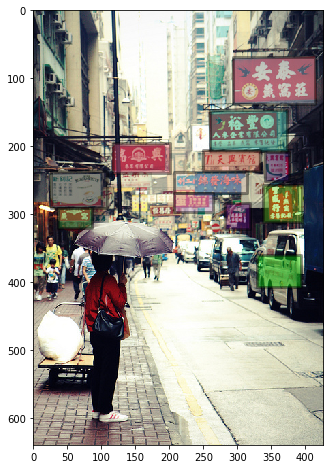

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

## get imgIds
imgIds = ct.getImgIds(imgIds=ct.train, catIds=[('legibility', 'legible')])
idx = np.random.randint(0,len(imgIds))
print("idx = {}".format(idx))

img = ct.loadImgs(imgIds[idx])[0]
print(img)
## show img
I = io.imread(os.path.join(dataDir, dataType, img['file_name']))
#I = io.imread(os.path.join(dataDir, dataType, "COCO_train2014_000000022582.jpg"))
plt.figure()
plt.imshow(I)

## show anns
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
print(anns)
ct.showAnns(anns)
